# testing outlier detection methods

## we test 6 different outlier detecton methods

- Magnitude of displacement
- Absolute median difference
- Local Outlier Factor (LOF)
- Hierarchical Density Based Spatial Clustering for Applicationws with Noise (HDBSCAN)
- Global Local Outlier Score base on Hierarchies (GLOSH)
- mean of Absolute median difference and HDBSCAN

## use following pair for testing
- 2020-09-27 -> 2020-11-13 B_perp = 4 m , B_temp = 47 days, contains 3-5 m of offset in range and azimuth


## To get the optimal parameters, we test over different values for:


- Magnitude
    - no parameters to vary
- Absolute Median difference
    - vary filter radius from 2-9 pixels
- LOF
    - k-nearest neighbours (smaller number -> local outliers, larger number -> global outliers) from 50 to 500 estimates/neighbours
- HDBSCAN
    - Minimum cluster size (larger minimum cluster size = more points labeled as outliers) from 50 to 500 estimates/neighbours
    - Minimum samples (similar to k-nearest neighbours) - smaller values means clusters get combined more often, smaller values -> fewer outliers
        - calculate as fraction of minimum clister size
- GLOSH
    - Minimum samples (similar to k-nearest neighbours) - smaller values means clusters get combined more often, smaller values -> fewer outliers
    - Minimum cluster size (does not control the creation of the dendrogram but minimum samples cannot go beyond minimum cluster size.)

## we aim to use tested based on performance statistics from manually labeled data
    - ROC curves
    - area under the curve values

    

### load dependencies

In [1]:
# import external packages
import numpy as np
import pandas as pd
import numba
from numba import vectorize
import glob # for file search
import copy
import os # operating system stuff
import re # regex
import fastparquet # fast read/write for large data structures
import sklearn.preprocessing as pre # for data normalisation
from sklearn.metrics import pairwise_distances

import geopandas as gpd
import rasterio as rio
import rasterio.mask
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon
from shapely.geometry.point import Point
import pyproj
from pyproj import CRS
from inpoly import inpoly2 # for fast inpolygon checks
import utm

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib import cm as mpl_cm
from matplotlib import colors as mcolors 

from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
from matplotlib import rc_file_defaults
rc_file_defaults()
# sns.set(style=None, color_codes=True)

from shapely.geometry import Polygon
from shapely.geometry.point import Point
import datetime

import configparser

from cmcrameri import cm # for scientific colourmaps

###########################
# import main local package
import SPOTSAR_main as sm


### load constants and user defined parameters

In [2]:
################ Define user INPUTS #######################
######## please edit the values of this block only ########
###########################################################

# define hillshade file
HS_FILE = './test_data/DEM/TDX_Merapi_WGS84_HS.tif'

# define lon and lat files
LON_FILE = './test_data/CSK_dsc/geo2/20200910.lon'
LAT_FILE = './test_data/CSK_dsc/geo2/20200910.lat'

# define parameter text file
PARAM_FILE = './test_data/CSK_dsc/params.txt'

# define map region of interest
lon_lims = [110.425, 110.45]
lat_lims = [-7.555, -7.535]

# define colour range {min max} (min = -max)
vmax = 3 # range of colourscale in meters

# define file names for data, lon and lat
DIRECTORY_PATH = "./test_data/CSK_dsc/DISP_txt2/"
# define path to ccp and ccs files
DIRECTORY_PATH_CCS = "./test_data/CSK_dsc/CCS2/"

# Set the regular expression pattern to match the file names
PATTERN1 = r"^c20200927_c20201113_disp_[0-9]+_[0-9]+\.txt$"


# Set the regular expression pattern to match the ccs file names
PATTERN_CCS1 = r"^c20200927_c20201113_ccs_[0-9]+_[0-9]+$"



# open hillshade file and re-order offset and CCS files

# open hill shade file with rasterio
DEM_HS = rio.open(HS_FILE)
SHADING = DEM_HS.read(1,masked=True) # rasterio bands are indexed from 1

# extract DEM extent
DEM_EXTENT=[DEM_HS.bounds.left,DEM_HS.bounds.right,DEM_HS.bounds.bottom,DEM_HS.bounds.top]

# read parameters from text file
config = configparser.ConfigParser()
config.read(PARAM_FILE)
WIDTH = int(config.get('params', 'width'))
LINES = int(config.get('params', 'lines'))
WIDTH_CCS = int(config.get('params', 'width_ccs'))
LINES_CCS = int(config.get('params', 'lines_ccs'))
R_START = int(config.get('params', 'r_start'))
A_START = int(config.get('params', 'a_start'))
R_STEP = int(config.get('params', 'r_step'))
A_STEP = int(config.get('params', 'a_step'))
HEADING = float(config.get('params', 'heading'))
MEAN_INC = float(config.get('params', 'mean_inc'))

### reorder files by date

In [3]:

# reorder file using Post_processing.reorder_files
matching_files1 = sm.Post_processing.reorder_files(DIRECTORY_PATH,PATTERN1,0)
matching_files_ccs1 = sm.Post_processing.reorder_files(DIRECTORY_PATH_CCS,PATTERN_CCS1,0)

# test if file ordering has worked
print(matching_files1)
print(matching_files_ccs1)


['c20200927_c20201113_disp_58_28.txt', 'c20200927_c20201113_disp_140_68.txt', 'c20200927_c20201113_disp_224_108.txt', 'c20200927_c20201113_disp_306_148.txt', 'c20200927_c20201113_disp_388_188.txt']
['c20200927_c20201113_ccs_58_28', 'c20200927_c20201113_ccs_140_68', 'c20200927_c20201113_ccs_224_108', 'c20200927_c20201113_ccs_306_148', 'c20200927_c20201113_ccs_388_188']


## Load data into single kernel objects and collect single kernel objects into mlti-kernel object

In [4]:

# load data from files into class multi-kernel
example_pairs = []
for (matching_files,matching_files_ccs) in zip([matching_files1],[matching_files_ccs1]):
    datastack = sm.Post_processing.MultiKernel(DIRECTORY_PATH,
                                            matching_files,
                                            DIRECTORY_PATH_CCS,
                                            matching_files_ccs,
                                            LAT_FILE,
                                            LON_FILE,
                                            HEADING,
                                            MEAN_INC,
                                            LINES_CCS,
                                            WIDTH_CCS)
    # We need to assign some data not stored in the disp.txt files.
    datastack.get_params_from_file_name()
    datastack.get_latlon_from_file(WIDTH)
    datastack.add_lat_lon_to_data(R_START,A_START)
    datastack.crop_stack_ccs(R_STEP,A_STEP)
    # the object datastack now has several attributes associated with the whole dataset (e.g., date1, date2, heading)
    # Next we add all the offset data (disp.txt) to the stack
    stacked_data = datastack.assign_data_to_stack(R_STEP,A_STEP)
    # The attribute 'Stack' we find a list of single-kernel objects which contain the actual offset data, ccp and ccs data and the coordinates.

    # add stack to list
    example_pairs.append(datastack)



#### plot to test if data loading worked

In [11]:
%matplotlib osx
sm.plot.plot_vec_attr(example_pairs[0].Stack[2],'Phase',2,50,0.005,[0,360],5,SHADING,DEM_EXTENT)

(<Figure size 1600x1600 with 2 Axes>,
 <Axes: title={'center': 'Phase: min = 0.0007761827936008103 max = 359.9995921165904'}>)

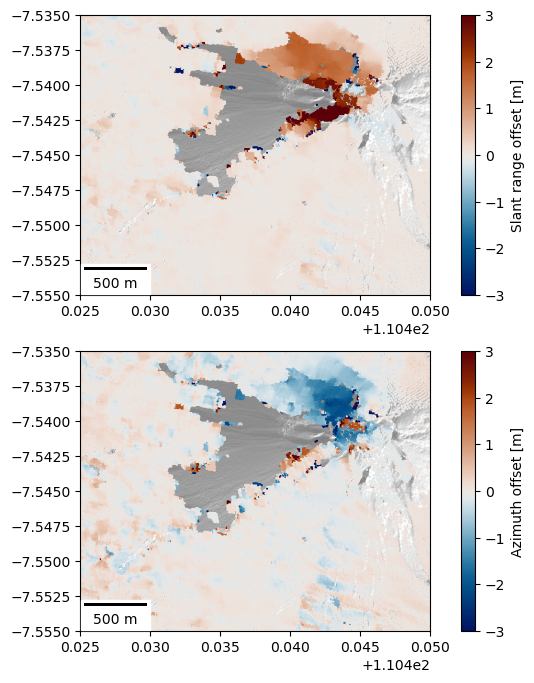

In [5]:
## plot range and azimuth offset separately.
test_obj = example_pairs[0].Stack[2]
lon_lims = [110.425, 110.45]
lat_lims = [-7.555, -7.535]

sm.plot.plot_ra_offsets(test_obj,SHADING,DEM_EXTENT,[-3,3],grid_size=1000,lat_lims=lat_lims,lon_lims=lon_lims,cmap=cm.vik)

### manually labeling outliers
We give each point the following handles:

- 0: singular outlier
- 1: grouped outlier
- 2: inlier no def
- 3: inlier def

We also label each data point as either low or high confidence

We manually label about 400 randomly selected points from each image pair and each window size.


In [7]:
do_labeling = False # flag to skip labeling if you are running the entire notebook
mag_thresh = 2 # for initial outlier filtering to select testing data. 
import random
import csv
from IPython.display import clear_output
if do_labeling:
    N_test = 40000
    test_obj = example_pairs[0].Stack[0]
    # get set of random integers for dataset testing:
    idx_rand = np.array([random.randint(0,np.size(test_obj.R_off_vec)-1) for i in range(N_test)])
    print(idx_rand)
    print(test_obj.Mag_vec[idx_rand])
    idx_rand = idx_rand[np.argwhere(test_obj.Mag_vec[idx_rand]>mag_thresh)]
    print(test_obj.R_win, test_obj.A_win)

    # col_ids = getattr(test_obj,'Col_index_vec')
    # row_ids = getattr(test_obj,'Row_index_vec')

    # mask = (col_ids>=500) & (col_ids<=800) & (row_ids>=100) & (row_ids<=450) & (np.mod(col_ids,10)==0) & (np.mod(row_ids,10)==0)
    # idx_rand = np.argwhere(mask)
    # print(row_ids[mask])

In [8]:
%matplotlib inline
# manually check many different vectors to classify as outlier, inlier and confidence on deformation

## make testing data0002
# store R_idx, A_idx, in/out flag, def flag
# outlier flag:
# 0: singular outlier
# 1: grouped outlier
# 2: def not moving
# 3: def moving

# confidence flag:
# 0: high
# 1: low
if do_labeling:


    test_file = f'./test_data/CSK_dsc/{test_obj.Name[0:-4]}_test_set4.csv'
    wL2_thresh = 10 # local L2 norm threshold for more outlier filtering before labeling
    init_csv = int(input('initialize csv file?'))

    # writing to csv file 
    if init_csv == 1:
        with open(test_file, 'w') as csvfile: 
            # creating a csv writer object 
            csvwriter = csv.writer(csvfile) 
                
            # writing the fields 
            csvwriter.writerow(['R idx', 'A idx', 'in/out flag', 'def flag']) 

    test_data = []
    counter = 1
    counter_start = 0
    for idx in idx_rand:
        if counter<=counter_start:
            counter+=1
            continue
        if np.mod(counter,10)==0:
            test_data_df = pd.DataFrame(test_data)
            test_data_df.to_csv(test_file, mode='a', index=False, header=False)
            test_data = []
        # plot selected offset vector in red with neioghbouring vectors in grey
        out = sm.plot.plot_rand_vec_skip(test_obj,idx,5,0.002,0.3,2,wL2_thresh,mag_thresh)
        # out = sm.plot.plot_rand_vec(test_obj,idx,5,0.002,0.3,2)
        if out == 0:
            continue

        # ask user to classify query point
        plt.show(block=False)
        in_out_flag = int(input('what is the in/out flag? 0: singular outlier, 1: grouped outlier,  2: inlier not moving, 3: inlier moving'))
        if in_out_flag not in [0,1,2,3]:
            print('ERROR: flag needs to be 0, 1, 2, or 3')
            print(f'counter: {counter}')
            break
        def_flag = int(input('what is the conf flag? 0: high conf, 1: low conf'))
        if def_flag not in [0,1]:
            print('ERROR: flag needs to be 0, 1')
            print(f'counter: {counter}')
            break
        test_data.append([test_obj.R_idx_vec[idx], test_obj.A_idx_vec[idx], in_out_flag, def_flag])
        plt.clf()
        clear_output(wait=True)
        counter += 1
    # write ansers to file
    test_data = pd.DataFrame(test_data)
    test_data.to_csv(test_file, mode='a', index=False, header=False)

In [9]:
plt.close('all')

In [10]:
# if your labeling was off and you had to terminate the program early. run this script to add the last bit of buffer to the csv file. 
if do_labeling:
    test_data.append([test_obj.R_idx_vec[idx], test_obj.A_idx_vec[idx], in_out_flag, def_flag])
    test_data = pd.DataFrame(test_data)
    test_data.to_csv(test_file, mode='a', index=False, header=False)

## check outlier detection via confusion matrix

Plot ROC curves for each method:
- magnitude
- absolute median difference
- LOF
- GLOSH
- HDBSCAN
- COMB (median + HDBSCAN)

for absolute median difference, vary filter radius

for LOF, GLOSH and HDBSCAN vary k neierest neighbors/ min cluster size

for HDBSCAN and GLOSH vary min samples


In [ ]:
# flag for performing time intensive classifications
do_classification = False

In [29]:
# run outlier detection for several k-nn values
import time

if do_classification:
    HDBSCAN_list = []
    GLOSH_list = []
    LOF_list = []
    Median_list = []
    filter_radius = [2,3,4,5,6,7,8,9]
    min_clusters = [50, 100, 150, 200, 250, 300, 400, 500]
    min_samples_facts = [0.00001, 0.1, 0.2, 0.3, 0.4, 0.5]
    obj = example_pairs[0].Stack[4]
    h5_file = f'./test_data/CSK_dsc/hdf5_files/{obj.Name[0:-4]}_outlier_detected_rot.h5'
    obj.prep_DBSCAN(1,1,100)
    obj.run_PCA(4)
    start = time.time()

    for (min_cluster, filt_rad) in zip(min_clusters,filter_radius):
        for min_samples_fact in min_samples_facts:
            min_samples = np.max([1,np.round(min_samples_fact*min_cluster)])
            print(f'N overlap: {min_cluster} min_samples: {min_samples}({min_samples_fact})')
            print('do HDBSCAN')
            f = h5py.File(h5_file,'a')
            if f'HDBSCAN_labels_{int(min_cluster)}_{int(min_samples)}_vec' not in f:
                f.close()
                HDBSCAN_labels, GLOSH_probabilities, HDBSCAN_probabilities = obj.run_HDBSCAN(int(min_cluster),int(min_samples),False,0.0)
                HDBSCAN_list.append( HDBSCAN_probabilities)
                GLOSH_list.append(GLOSH_probabilities)
                obj.to_hdf5(h5_file,[f'HDBSCAN_labels_{int(min_cluster)}_{int(min_samples)}_vec',
                                    f'HDBSCAN_outlier_scores_{int(min_cluster)}_{int(min_samples)}_vec',
                                    f'HDBSCAN_probabilities_{int(min_cluster)}_{int(min_samples)}_vec',
                                    f'HDBSCAN_labels_{int(min_cluster)}_{int(min_samples)}',
                                    f'HDBSCAN_outlier_scores_{int(min_cluster)}_{int(min_samples)}',
                                    f'HDBSCAN_probabilities_{int(min_cluster)}_{int(min_samples)}'])
            HDBSCAN_list.append(HDBSCAN_probabilities)
            GLOSH_list.append(GLOSH_probabilities)
            print(f'time: {time.time()-start}')
            
        print('do LOF')
        f = h5py.File(h5_file,'a')
        if f'LOF_labels_{int(min_cluster)}_vec' not in f:
            f.close()
            LOF_labels, LOF_negative_score = obj.run_LOF(n_neighbors=int(min_cluster),algorithm='auto',leaf_size=30,contamination='auto')
            obj.to_hdf5(h5_file,[f'LOF_labels_{int(min_cluster)}_vec',
                                f'LOF_outlier_score_{int(min_cluster)}_vec',
                                f'LOF_labels_{int(min_cluster)}',
                                f'LOF_outlier_scores_{int(min_cluster)}'])
            
            LOF_list.append(LOF_negative_score)
        print(f'time: {time.time()-start}')
        
        print('do med filt',filt_rad)
        f = h5py.File(h5_file,'a')
        if f'Mag_off_med_diff_{filt_rad}_vec' not in f:
            f.close()
            R_off_med_diff, A_off_med_diff, mag_off_med_diff = obj.run_med_filt(filt_rad)
            obj.to_hdf5(h5_file,[f'Mag_off_med_diff_{filt_rad}_vec',
                                f'Mag_off_med_diff_{filt_rad}'])
            Median_list.append(mag_off_med_diff)
        print(f'time: {time.time()-start}')


N overlap: 50 min_samples: 1.0(1e-05)
do HDBSCAN
time: 104.09136724472046
N overlap: 50 min_samples: 5.0(0.1)
do HDBSCAN
time: 210.48397207260132
N overlap: 50 min_samples: 10.0(0.2)
do HDBSCAN
time: 266.84265899658203
N overlap: 50 min_samples: 15.0(0.3)
do HDBSCAN
time: 309.7330141067505
N overlap: 50 min_samples: 20.0(0.4)
do HDBSCAN
time: 355.4842212200165
N overlap: 50 min_samples: 25.0(0.5)
do HDBSCAN
time: 400.4254081249237
do LOF
time: 425.0187740325928
N overlap: 100 min_samples: 1.0(1e-05)
do HDBSCAN
time: 452.93972396850586
N overlap: 100 min_samples: 10.0(0.1)
do HDBSCAN
time: 479.3660662174225
N overlap: 100 min_samples: 20.0(0.2)
do HDBSCAN
time: 505.27319598197937
N overlap: 100 min_samples: 30.0(0.3)
do HDBSCAN
time: 532.0825819969177
N overlap: 100 min_samples: 40.0(0.4)
do HDBSCAN
time: 563.4564909934998
N overlap: 100 min_samples: 50.0(0.5)
do HDBSCAN
time: 597.4641251564026
do LOF
time: 636.7947499752045
N overlap: 150 min_samples: 1.0(1e-05)
do HDBSCAN
time: 681.51

## code to load outlier detection results from hdf5 file

In [27]:
if do_classification==False:
    import h5py
    filename = './test_data/CSK_dsc/hdf5_files/c20200927_c20201113_disp_388_188_outlier_detected_rot.h5'
    f= h5py.File(filename,'a')
    # f.__delitem__('LOF_labels_16_vec')
    # f.__delitem__('LOF_labels_16')

    print(f.keys())
    f.close()

<KeysViewHDF5 ['HDBSCAN_labels_100_1', 'HDBSCAN_labels_100_10', 'HDBSCAN_labels_100_10_vec', 'HDBSCAN_labels_100_1_vec', 'HDBSCAN_labels_100_20', 'HDBSCAN_labels_100_20_vec', 'HDBSCAN_labels_100_30', 'HDBSCAN_labels_100_30_vec', 'HDBSCAN_labels_100_40', 'HDBSCAN_labels_100_40_vec', 'HDBSCAN_labels_100_50', 'HDBSCAN_labels_100_50_vec', 'HDBSCAN_labels_150_1', 'HDBSCAN_labels_150_15', 'HDBSCAN_labels_150_15_vec', 'HDBSCAN_labels_150_1_vec', 'HDBSCAN_labels_150_30', 'HDBSCAN_labels_150_30_vec', 'HDBSCAN_labels_150_45', 'HDBSCAN_labels_150_45_vec', 'HDBSCAN_labels_150_60', 'HDBSCAN_labels_150_60_vec', 'HDBSCAN_labels_150_75', 'HDBSCAN_labels_150_75_vec', 'HDBSCAN_labels_200_1', 'HDBSCAN_labels_200_100', 'HDBSCAN_labels_200_100_vec', 'HDBSCAN_labels_200_1_vec', 'HDBSCAN_labels_200_20', 'HDBSCAN_labels_200_20_vec', 'HDBSCAN_labels_200_40', 'HDBSCAN_labels_200_40_vec', 'HDBSCAN_labels_200_60', 'HDBSCAN_labels_200_60_vec', 'HDBSCAN_labels_200_80', 'HDBSCAN_labels_200_80_vec', 'HDBSCAN_labels_2

In [9]:
if do_classification==False:

    # save_keys = ['R_idx','A_idx','Row_index','Col_index','Lon_off','Lat_off','R_off','A_off']
    # for key in dir(obj[0]):
    #     if ('HDBSCAN' == key[0:7]) and (key[-3:] != 'vec'):
    #         save_keys.append(key)
    #     if ('GLOSH' == key[0:5]) and  (key[-3:] != 'vec'):
    #         save_keys.append(key)
    #     if ('LOF' == key[0:3]) and  (key[-3:] != 'vec'):
    #         save_keys.append(key)
    # print(save_keys)
    # obj[0].to_hdf5(f'./test_data/CSK_dsc/hdf5_files/{obj[0].Name[0:-4]}_outlier_detected.h5',save_keys)
    objs = example_pairs[0].Stack

    files = [f'./test_data/CSK_dsc/hdf5_files/{example_pairs[0].Stack[0].Name[0:-4]}_outlier_detected2.h5',
            f'./test_data/CSK_dsc/hdf5_files/{example_pairs[0].Stack[1].Name[0:-4]}_outlier_detected_rot.h5',
            f'./test_data/CSK_dsc/hdf5_files/{example_pairs[0].Stack[2].Name[0:-4]}_outlier_detected_rot.h5',
            f'./test_data/CSK_dsc/hdf5_files/{example_pairs[0].Stack[3].Name[0:-4]}_outlier_detected_rot.h5',
            f'./test_data/CSK_dsc/hdf5_files/{example_pairs[0].Stack[4].Name[0:-4]}_outlier_detected_rot.h5',
            ]
    # f = h5py.File(f'./test_data/CSK_dsc/hdf5_files/{obj.Name[0:-4]}_outlier_detected.h5')
    query_keys = ['HDBSCAN_labels_100_1', 'HDBSCAN_labels_100_10', 'HDBSCAN_labels_100_10_vec', 'HDBSCAN_labels_100_1_vec', 'HDBSCAN_labels_100_20', 'HDBSCAN_labels_100_20_vec', 'HDBSCAN_labels_100_30', 'HDBSCAN_labels_100_30_vec', 'HDBSCAN_labels_100_40', 'HDBSCAN_labels_100_40_vec', 'HDBSCAN_labels_100_50', 'HDBSCAN_labels_100_50_vec', 'HDBSCAN_labels_150_1', 'HDBSCAN_labels_150_15', 'HDBSCAN_labels_150_15_vec', 'HDBSCAN_labels_150_1_vec', 'HDBSCAN_labels_150_30', 'HDBSCAN_labels_150_30_vec', 'HDBSCAN_labels_150_45', 'HDBSCAN_labels_150_45_vec', 'HDBSCAN_labels_150_60', 'HDBSCAN_labels_150_60_vec', 'HDBSCAN_labels_150_75', 'HDBSCAN_labels_150_75_vec', 'HDBSCAN_labels_200_1', 'HDBSCAN_labels_200_100', 'HDBSCAN_labels_200_100_vec', 'HDBSCAN_labels_200_1_vec', 'HDBSCAN_labels_200_20', 'HDBSCAN_labels_200_20_vec', 'HDBSCAN_labels_200_40', 'HDBSCAN_labels_200_40_vec', 'HDBSCAN_labels_200_60', 'HDBSCAN_labels_200_60_vec', 'HDBSCAN_labels_200_80', 'HDBSCAN_labels_200_80_vec', 'HDBSCAN_labels_250_1', 'HDBSCAN_labels_250_100', 'HDBSCAN_labels_250_100_vec', 'HDBSCAN_labels_250_125', 'HDBSCAN_labels_250_125_vec', 'HDBSCAN_labels_250_1_vec', 'HDBSCAN_labels_250_25', 'HDBSCAN_labels_250_25_vec', 'HDBSCAN_labels_250_50', 'HDBSCAN_labels_250_50_vec', 'HDBSCAN_labels_250_75', 'HDBSCAN_labels_250_75_vec', 'HDBSCAN_labels_300_1', 'HDBSCAN_labels_300_120', 'HDBSCAN_labels_300_120_vec', 'HDBSCAN_labels_300_150', 'HDBSCAN_labels_300_150_vec', 'HDBSCAN_labels_300_1_vec', 'HDBSCAN_labels_300_30', 'HDBSCAN_labels_300_30_vec', 'HDBSCAN_labels_300_60', 'HDBSCAN_labels_300_60_vec', 'HDBSCAN_labels_300_90', 'HDBSCAN_labels_300_90_vec', 'HDBSCAN_labels_400_1', 'HDBSCAN_labels_400_120', 'HDBSCAN_labels_400_120_vec', 'HDBSCAN_labels_400_160', 'HDBSCAN_labels_400_160_vec', 'HDBSCAN_labels_400_1_vec', 'HDBSCAN_labels_400_200', 'HDBSCAN_labels_400_200_vec', 'HDBSCAN_labels_400_40', 'HDBSCAN_labels_400_40_vec', 'HDBSCAN_labels_400_80', 'HDBSCAN_labels_400_80_vec', 'HDBSCAN_labels_500_1', 'HDBSCAN_labels_500_100', 'HDBSCAN_labels_500_100_vec', 'HDBSCAN_labels_500_150', 'HDBSCAN_labels_500_150_vec', 'HDBSCAN_labels_500_1_vec', 'HDBSCAN_labels_500_200', 'HDBSCAN_labels_500_200_vec', 'HDBSCAN_labels_500_250', 'HDBSCAN_labels_500_250_vec', 'HDBSCAN_labels_500_50', 'HDBSCAN_labels_500_50_vec', 'HDBSCAN_labels_50_1', 'HDBSCAN_labels_50_10', 'HDBSCAN_labels_50_10_vec', 'HDBSCAN_labels_50_15', 'HDBSCAN_labels_50_15_vec', 'HDBSCAN_labels_50_1_vec', 'HDBSCAN_labels_50_20', 'HDBSCAN_labels_50_20_vec', 'HDBSCAN_labels_50_25', 'HDBSCAN_labels_50_25_vec', 'HDBSCAN_labels_50_5', 'HDBSCAN_labels_50_5_vec', 'HDBSCAN_outlier_scores_100_1', 'HDBSCAN_outlier_scores_100_10', 'HDBSCAN_outlier_scores_100_10_vec', 'HDBSCAN_outlier_scores_100_1_vec', 'HDBSCAN_outlier_scores_100_20', 'HDBSCAN_outlier_scores_100_20_vec', 'HDBSCAN_outlier_scores_100_30', 'HDBSCAN_outlier_scores_100_30_vec', 'HDBSCAN_outlier_scores_100_40', 'HDBSCAN_outlier_scores_100_40_vec', 'HDBSCAN_outlier_scores_100_50', 'HDBSCAN_outlier_scores_100_50_vec', 'HDBSCAN_outlier_scores_150_1', 'HDBSCAN_outlier_scores_150_15', 'HDBSCAN_outlier_scores_150_15_vec', 'HDBSCAN_outlier_scores_150_1_vec', 'HDBSCAN_outlier_scores_150_30', 'HDBSCAN_outlier_scores_150_30_vec', 'HDBSCAN_outlier_scores_150_45', 'HDBSCAN_outlier_scores_150_45_vec', 'HDBSCAN_outlier_scores_150_60', 'HDBSCAN_outlier_scores_150_60_vec', 'HDBSCAN_outlier_scores_150_75', 'HDBSCAN_outlier_scores_150_75_vec', 'HDBSCAN_outlier_scores_200_1', 'HDBSCAN_outlier_scores_200_100', 'HDBSCAN_outlier_scores_200_100_vec', 'HDBSCAN_outlier_scores_200_1_vec', 'HDBSCAN_outlier_scores_200_20', 'HDBSCAN_outlier_scores_200_20_vec', 'HDBSCAN_outlier_scores_200_40', 'HDBSCAN_outlier_scores_200_40_vec', 'HDBSCAN_outlier_scores_200_60', 'HDBSCAN_outlier_scores_200_60_vec', 'HDBSCAN_outlier_scores_200_80', 'HDBSCAN_outlier_scores_200_80_vec', 'HDBSCAN_outlier_scores_250_1', 'HDBSCAN_outlier_scores_250_100', 'HDBSCAN_outlier_scores_250_100_vec', 'HDBSCAN_outlier_scores_250_125', 'HDBSCAN_outlier_scores_250_125_vec', 'HDBSCAN_outlier_scores_250_1_vec', 'HDBSCAN_outlier_scores_250_25', 'HDBSCAN_outlier_scores_250_25_vec', 'HDBSCAN_outlier_scores_250_50', 'HDBSCAN_outlier_scores_250_50_vec', 'HDBSCAN_outlier_scores_250_75', 'HDBSCAN_outlier_scores_250_75_vec', 'HDBSCAN_outlier_scores_300_1', 'HDBSCAN_outlier_scores_300_120', 'HDBSCAN_outlier_scores_300_120_vec', 'HDBSCAN_outlier_scores_300_150', 'HDBSCAN_outlier_scores_300_150_vec', 'HDBSCAN_outlier_scores_300_1_vec', 'HDBSCAN_outlier_scores_300_30', 'HDBSCAN_outlier_scores_300_30_vec', 'HDBSCAN_outlier_scores_300_60', 'HDBSCAN_outlier_scores_300_60_vec', 'HDBSCAN_outlier_scores_300_90', 'HDBSCAN_outlier_scores_300_90_vec', 'HDBSCAN_outlier_scores_400_1', 'HDBSCAN_outlier_scores_400_120', 'HDBSCAN_outlier_scores_400_120_vec', 'HDBSCAN_outlier_scores_400_160', 'HDBSCAN_outlier_scores_400_160_vec', 'HDBSCAN_outlier_scores_400_1_vec', 'HDBSCAN_outlier_scores_400_200', 'HDBSCAN_outlier_scores_400_200_vec', 'HDBSCAN_outlier_scores_400_40', 'HDBSCAN_outlier_scores_400_40_vec', 'HDBSCAN_outlier_scores_400_80', 'HDBSCAN_outlier_scores_400_80_vec', 'HDBSCAN_outlier_scores_500_1', 'HDBSCAN_outlier_scores_500_100', 'HDBSCAN_outlier_scores_500_100_vec', 'HDBSCAN_outlier_scores_500_150', 'HDBSCAN_outlier_scores_500_150_vec', 'HDBSCAN_outlier_scores_500_1_vec', 'HDBSCAN_outlier_scores_500_200', 'HDBSCAN_outlier_scores_500_200_vec', 'HDBSCAN_outlier_scores_500_250', 'HDBSCAN_outlier_scores_500_250_vec', 'HDBSCAN_outlier_scores_500_50', 'HDBSCAN_outlier_scores_500_50_vec', 'HDBSCAN_outlier_scores_50_1', 'HDBSCAN_outlier_scores_50_10', 'HDBSCAN_outlier_scores_50_10_vec', 'HDBSCAN_outlier_scores_50_15', 'HDBSCAN_outlier_scores_50_15_vec', 'HDBSCAN_outlier_scores_50_1_vec', 'HDBSCAN_outlier_scores_50_20', 'HDBSCAN_outlier_scores_50_20_vec', 'HDBSCAN_outlier_scores_50_25', 'HDBSCAN_outlier_scores_50_25_vec', 'HDBSCAN_outlier_scores_50_5', 'HDBSCAN_outlier_scores_50_5_vec', 'HDBSCAN_probabilities_100_1', 'HDBSCAN_probabilities_100_10', 'HDBSCAN_probabilities_100_10_vec', 'HDBSCAN_probabilities_100_1_vec', 'HDBSCAN_probabilities_100_20', 'HDBSCAN_probabilities_100_20_vec', 'HDBSCAN_probabilities_100_30', 'HDBSCAN_probabilities_100_30_vec', 'HDBSCAN_probabilities_100_40', 'HDBSCAN_probabilities_100_40_vec', 'HDBSCAN_probabilities_100_50', 'HDBSCAN_probabilities_100_50_vec', 'HDBSCAN_probabilities_150_1', 'HDBSCAN_probabilities_150_15', 'HDBSCAN_probabilities_150_15_vec', 'HDBSCAN_probabilities_150_1_vec', 'HDBSCAN_probabilities_150_30', 'HDBSCAN_probabilities_150_30_vec', 'HDBSCAN_probabilities_150_45', 'HDBSCAN_probabilities_150_45_vec', 'HDBSCAN_probabilities_150_60', 'HDBSCAN_probabilities_150_60_vec', 'HDBSCAN_probabilities_150_75', 'HDBSCAN_probabilities_150_75_vec', 'HDBSCAN_probabilities_200_1', 'HDBSCAN_probabilities_200_100', 'HDBSCAN_probabilities_200_100_vec', 'HDBSCAN_probabilities_200_1_vec', 'HDBSCAN_probabilities_200_20', 'HDBSCAN_probabilities_200_20_vec', 'HDBSCAN_probabilities_200_40', 'HDBSCAN_probabilities_200_40_vec', 'HDBSCAN_probabilities_200_60', 'HDBSCAN_probabilities_200_60_vec', 'HDBSCAN_probabilities_200_80', 'HDBSCAN_probabilities_200_80_vec', 'HDBSCAN_probabilities_250_1', 'HDBSCAN_probabilities_250_100', 'HDBSCAN_probabilities_250_100_vec', 'HDBSCAN_probabilities_250_125', 'HDBSCAN_probabilities_250_125_vec', 'HDBSCAN_probabilities_250_1_vec', 'HDBSCAN_probabilities_250_25', 'HDBSCAN_probabilities_250_25_vec', 'HDBSCAN_probabilities_250_50', 'HDBSCAN_probabilities_250_50_vec', 'HDBSCAN_probabilities_250_75', 'HDBSCAN_probabilities_250_75_vec', 'HDBSCAN_probabilities_300_1', 'HDBSCAN_probabilities_300_120', 'HDBSCAN_probabilities_300_120_vec', 'HDBSCAN_probabilities_300_150', 'HDBSCAN_probabilities_300_150_vec', 'HDBSCAN_probabilities_300_1_vec', 'HDBSCAN_probabilities_300_30', 'HDBSCAN_probabilities_300_30_vec', 'HDBSCAN_probabilities_300_60', 'HDBSCAN_probabilities_300_60_vec', 'HDBSCAN_probabilities_300_90', 'HDBSCAN_probabilities_300_90_vec', 'HDBSCAN_probabilities_400_1', 'HDBSCAN_probabilities_400_120', 'HDBSCAN_probabilities_400_120_vec', 'HDBSCAN_probabilities_400_160', 'HDBSCAN_probabilities_400_160_vec', 'HDBSCAN_probabilities_400_1_vec', 'HDBSCAN_probabilities_400_200', 'HDBSCAN_probabilities_400_200_vec', 'HDBSCAN_probabilities_400_40', 'HDBSCAN_probabilities_400_40_vec', 'HDBSCAN_probabilities_400_80', 'HDBSCAN_probabilities_400_80_vec', 'HDBSCAN_probabilities_500_1', 'HDBSCAN_probabilities_500_100', 'HDBSCAN_probabilities_500_100_vec', 'HDBSCAN_probabilities_500_150', 'HDBSCAN_probabilities_500_150_vec', 'HDBSCAN_probabilities_500_1_vec', 'HDBSCAN_probabilities_500_200', 'HDBSCAN_probabilities_500_200_vec', 'HDBSCAN_probabilities_500_250', 'HDBSCAN_probabilities_500_250_vec', 'HDBSCAN_probabilities_500_50', 'HDBSCAN_probabilities_500_50_vec', 'HDBSCAN_probabilities_50_1', 'HDBSCAN_probabilities_50_10', 'HDBSCAN_probabilities_50_10_vec', 'HDBSCAN_probabilities_50_15', 'HDBSCAN_probabilities_50_15_vec', 'HDBSCAN_probabilities_50_1_vec', 'HDBSCAN_probabilities_50_20', 'HDBSCAN_probabilities_50_20_vec', 'HDBSCAN_probabilities_50_25', 'HDBSCAN_probabilities_50_25_vec', 'HDBSCAN_probabilities_50_5', 'HDBSCAN_probabilities_50_5_vec', 'LOF_labels_100', 'LOF_labels_100_vec', 'LOF_labels_150', 'LOF_labels_150_vec', 'LOF_labels_200', 'LOF_labels_200_vec', 'LOF_labels_250', 'LOF_labels_250_vec', 'LOF_labels_300', 'LOF_labels_300_vec', 'LOF_labels_400', 'LOF_labels_400_vec', 'LOF_labels_50', 'LOF_labels_500', 'LOF_labels_500_vec', 'LOF_labels_50_vec', 'LOF_outlier_score_100_vec', 'LOF_outlier_score_150_vec', 'LOF_outlier_score_200_vec', 'LOF_outlier_score_250_vec', 'LOF_outlier_score_300_vec', 'LOF_outlier_score_400_vec', 'LOF_outlier_score_500_vec', 'LOF_outlier_score_50_vec', 'LOF_outlier_scores_100', 'LOF_outlier_scores_150', 'LOF_outlier_scores_200', 'LOF_outlier_scores_250', 'LOF_outlier_scores_300', 'LOF_outlier_scores_400', 'LOF_outlier_scores_50', 'LOF_outlier_scores_500', 'Mag_off_med_diff_2', 'Mag_off_med_diff_2_vec', 'Mag_off_med_diff_3', 'Mag_off_med_diff_3_vec', 'Mag_off_med_diff_4', 'Mag_off_med_diff_4_vec', 'Mag_off_med_diff_5', 'Mag_off_med_diff_5_vec', 'Mag_off_med_diff_6', 'Mag_off_med_diff_6_vec', 'Mag_off_med_diff_7', 'Mag_off_med_diff_7_vec', 'Mag_off_med_diff_8', 'Mag_off_med_diff_8_vec', 'Mag_off_med_diff_9', 'Mag_off_med_diff_9_vec']

    for (obj,file) in zip(objs,files):
        print(obj,file)
        obj.from_hdf5(file,query_keys)

## calculate outlier detection results 

In [60]:
%matplotlib osx
import pickle
import itertools
import random

from sklearn import metrics
from matplotlib.collections import LineCollection
plt.close('all')

# plotting conditions
plotting = 0
plotting_flag = 0
labels = 0
verbose= False

# dataset to test
obj = example_pairs[0].Stack[4]

min_samples_facts = [0.00001, 0.1, 0.2, 0.3, 0.4, 0.5]
min_cluster_sizes = [50,100,150,200,250,300,400,500]
filter_radius = [2,3,4,5,6,7,8,9]

n_cat = 50 # number of samples from each catergory of inlier/outlier
n_runs = 1 # number of runs

# get data
r_win = getattr(obj, "R_win")
a_win = getattr(obj, "A_win")
r_idx = getattr(obj, "R_idx")
a_idx = getattr(obj, "A_idx")

# get testing data
test_data1 = pd.read_csv(
            f"./test_data/CSK_dsc/{obj.Name[:-4]}_test_set.csv", header=0
        ).to_numpy()
test_data2 = pd.read_csv(
            f"./test_data/CSK_dsc/{obj.Name[:-4]}_test_set3.csv", header=0
        ).to_numpy()

test_data3 = pd.read_csv(
            f"./test_data/CSK_dsc/{obj.Name[:-4]}_test_set4.csv", header=0
        ).to_numpy()

# select which test data to use
test_data4 = np.row_stack((test_data1,test_data2,test_data3))

test_data4 = np.unique(test_data4,axis=0)


In [61]:
# seperate based on category
# n_cat = 60
# test_data3 = test_data3[test_data3[:,3]==0]
sel0 = test_data4[test_data4[:,2]==0]
sel1 = test_data4[test_data4[:,2]==1]
sel2 = test_data4[test_data4[:,2]==2]
sel3 = test_data4[test_data4[:,2]==3]

# initialize outlut lists
auc_list = []
fpr_list = []
tpr_list = []
thresh_list = []

auc_mag_mat = np.empty((np.size(min_cluster_sizes),np.size(min_samples_facts),n_runs))
auc_med_mat = np.empty((np.size(min_cluster_sizes),np.size(min_samples_facts),n_runs))
auc_hdb_mat = np.empty((np.size(min_cluster_sizes),np.size(min_samples_facts),n_runs))
auc_glsh_mat = np.empty((np.size(min_cluster_sizes),np.size(min_samples_facts),n_runs))
auc_lof_mat = np.empty((np.size(min_cluster_sizes),np.size(min_samples_facts),n_runs))
auc_comb123_mat = np.empty((np.size(min_cluster_sizes),np.size(min_samples_facts),n_runs))
auc_comb23_mat = np.empty((np.size(min_cluster_sizes),np.size(min_samples_facts),n_runs))
# main loop
for run_id in range(n_runs):
    ax_id = 0
    # select n_cat point from each category of the testing data

    test_data = np.row_stack((sel0[random.sample(range(np.shape(sel0)[0]),k=n_cat),:],
                            sel1[random.sample(range(np.shape(sel1)[0]),k=n_cat),:],
                            sel2[random.sample(range(np.shape(sel2)[0]),k=n_cat),:],
                            sel3[random.sample(range(np.shape(sel3)[0]),k=n_cat),:]))
    # run for each minimum cluster size
    for clust_id, (min_clust_size, filt_rad) in enumerate(zip(min_cluster_sizes,filter_radius)):
        min_samples = [np.max([1, int(np.round(min_clust_size * min_samples_fact))]) for min_samples_fact in min_samples_facts]
        
        for samp_id, min_sample in enumerate(min_samples):
            
            # go through each method and collect relevant results
            print(run_id, ax_id)
            HDBSCAN_labels = getattr(
                obj, f"HDBSCAN_probabilities_{min_clust_size}_{min_sample}"
            )
            GLOSH_labels = getattr(
                obj, f"HDBSCAN_outlier_scores_{min_clust_size}_{min_sample}"
            )
            LOF_labels = getattr(obj, f"LOF_outlier_scores_{min_clust_size}")
            Mag_labels = getattr(obj, "Mag")
            Med_labels = getattr(obj, f"Mag_off_med_diff_{filt_rad}")

            # get coordinates and offsets for plotting vectors of testing data
            all_lons=getattr(obj,'Lon_off')
            all_lats=getattr(obj,'Lat_off')
            all_X_off=getattr(obj,'X_off')
            all_Y_off=getattr(obj,'Y_off')

            # get testing data
            test_labels = -1 * np.ones(np.shape(test_data[:, 1]))
            mask = (test_data[:, 2] > 1)
            test_labels[mask] = 1  # all inliers
            test_lats = np.empty_like(test_labels)
            test_lons = np.empty_like(test_labels)
            test_X_off = np.empty_like(test_labels)
            test_Y_off = np.empty_like(test_labels)
            for row_id,test_vec in enumerate(test_data):
                
                idx = np.argwhere((r_idx == int(test_vec[0])) & (a_idx == int(test_vec[1])))
                test_lats[row_id] = all_lats[idx[0][0], idx[0][1]]
                test_lons[row_id] = all_lons[idx[0][0], idx[0][1]]
                test_X_off[row_id] = all_X_off[idx[0][0], idx[0][1]]
                test_Y_off[row_id] = all_Y_off[idx[0][0], idx[0][1]]
            
            if plotting == 0:
                fig0, ax0 = plt.subplots(1,1)
                ax0.hist(test_data[:,2],4)
                fig1, ax = plt.subplots(1,1)
                ax.imshow(SHADING,cmap=cm.grayC,alpha=0.5, extent=DEM_EXTENT)
                q = ax.quiver(test_lons,test_lats,
                                test_X_off,test_Y_off,
                                test_data[:,2],
                                scale=50, 
                                width = 0.008, 
                                edgecolor='black',
                                linewidth=0.2)
                plotting = 1

            # collect results of methods for testing data points
            Mag_test_labels = np.full(np.shape(test_labels), np.nan)
            Med_test_labels = np.full(np.shape(test_labels), np.nan)
            HDBSCAN_test_labels = np.full(np.shape(test_labels), np.nan)
            GLOSH_test_labels = np.full(np.shape(test_labels), np.nan)
            LOF_test_labels = np.full(np.shape(test_labels), np.nan)
            for row_id, test_vec in enumerate(test_data):
                idx = np.argwhere((r_idx == int(test_vec[0])) & (a_idx == int(test_vec[1])))
                Mag_test_labels[row_id] = Mag_labels[idx[0][0], idx[0][1]]
                Med_test_labels[row_id] = Med_labels[idx[0][0], idx[0][1]]
                HDBSCAN_test_labels[row_id] = HDBSCAN_labels[idx[0][0], idx[0][1]]
                GLOSH_test_labels[row_id] = GLOSH_labels[idx[0][0], idx[0][1]]
                LOF_test_labels[row_id] = LOF_labels[idx[0][0], idx[0][1]]


            ## convert metric to inlier probability ##

            # magnitude filter (1 - normalised magnitude)
            p_in_mag = 1- (Mag_test_labels-np.nanmin(Mag_labels))/(np.nanmax(Mag_labels)-np.nanmin(Mag_labels))

            # Median filter (1 - max normalised median difference)
            p_in_med = 1- (Med_test_labels/(np.nanmax(Med_labels)))

            # LOF (normalised negative LOF)
            p_in_lof = (LOF_test_labels-np.nanmin(LOF_labels))/(np.nanmax(LOF_labels)-np.nanmin(LOF_labels))

            # HDBSCAN (probability of belonging to cluster (outliers have probability 0))
            p_in_hdb = HDBSCAN_test_labels

            # GLOSH (1 - outlier probability)
            p_in_glsh = 1-GLOSH_test_labels

            p_in_comb123 = (p_in_lof + p_in_glsh + p_in_hdb)/3

            p_in_comb23 = (p_in_hdb + p_in_med)/2




            # magnitude
            fpr_mag, tpr_mag, thresh_mag = metrics.roc_curve(
                test_labels[~np.isnan(p_in_mag)],
                p_in_mag[~np.isnan(p_in_mag)],
            )
            print(f'thresh mag [0]: {thresh_mag[0]} {thresh_mag[-1]}')
            auc_mag = metrics.roc_auc_score(
                test_labels[~np.isnan(p_in_mag)],
                p_in_mag[~np.isnan(p_in_mag)],
            )

            # magnitude
            fpr_med, tpr_med, thresh_med = metrics.roc_curve(
                test_labels[~np.isnan(p_in_med)],
                p_in_med[~np.isnan(p_in_med)],
            )
            print(f'thresh med [0]: {thresh_med[0]} {thresh_med[-1]}')
            auc_med = metrics.roc_auc_score(
                test_labels[~np.isnan(p_in_med)],
                p_in_med[~np.isnan(p_in_med)],
            )
            
            # HDBSCAN
            fpr_hdb, tpr_hdb, thresh_hdb = metrics.roc_curve(
                test_labels[~np.isnan(p_in_hdb)],
                p_in_hdb[~np.isnan(p_in_hdb)],
            )
            print(f'thresh hdb [0]: {thresh_hdb[0]} {thresh_hdb[-1]}')
            auc_hdb = metrics.roc_auc_score(
                test_labels[~np.isnan(p_in_hdb)],
                p_in_hdb[~np.isnan(p_in_hdb)],
            )
            store_hdb_1 = (fpr_hdb, tpr_hdb, thresh_hdb,auc_hdb)

            # GLOSH
            fpr_glsh, tpr_glsh, thresh_glsh = metrics.roc_curve(
                test_labels[~np.isnan(p_in_glsh)],
                p_in_glsh[~np.isnan(p_in_glsh)],
            )
            print(f'thresh glsh [0]: {thresh_glsh[0]} {thresh_glsh[-1]}')
            auc_glsh = metrics.roc_auc_score(
                test_labels[~np.isnan(p_in_glsh)],
                p_in_glsh[~np.isnan(p_in_glsh)],
            )

            # LOF
            fpr_lof, tpr_lof, thresh_lof = metrics.roc_curve(
                test_labels[~np.isnan(p_in_lof)],
                p_in_lof[~np.isnan(p_in_lof)],
            )
            print(f'thresh lof [0]: {thresh_lof[0]} {thresh_lof[-1]}')
            auc_lof = metrics.roc_auc_score(
                test_labels[~np.isnan(p_in_lof)],
                p_in_lof[~np.isnan(p_in_lof)],
            )

            # comb123
            fpr_comb123, tpr_comb123, thresh_comb123 = metrics.roc_curve(
                test_labels[~np.isnan(p_in_comb123)],
                p_in_comb123[~np.isnan(p_in_comb123)],
            )
            print(f'thresh comb123 [0]: {thresh_comb123[0]} {thresh_comb123[-1]}')
            auc_comb123 = metrics.roc_auc_score(
                test_labels[~np.isnan(p_in_comb123)],
                p_in_comb123[~np.isnan(p_in_comb123)],
            )

            # comb23
            fpr_comb23, tpr_comb23, thresh_comb23 = metrics.roc_curve(
                test_labels[~np.isnan(p_in_comb23)],
                p_in_comb23[~np.isnan(p_in_comb23)],
            )
            print(f'thresh comb23 [0]: {thresh_comb23[0]} {thresh_comb23[-1]}')
            auc_comb23 = metrics.roc_auc_score(
                test_labels[~np.isnan(p_in_comb23)],
                p_in_comb23[~np.isnan(p_in_comb23)],
            )
            

            if verbose:
                print(f'{ax_id} M min, max:{np.min(thresh_mag)},{np.max(thresh_mag)}')
                print(f'{ax_id} Med min, max:{np.min(thresh_med)},{np.max(thresh_med)}')
                print(f'{ax_id} H min, max:{np.min(thresh_hdb)},{np.max(thresh_hdb)}')
                print(f'{ax_id} G min, max:{np.min(thresh_glsh)},{np.max(thresh_glsh)}')
                print(f'{ax_id} L min, max:{np.min(thresh_lof)},{np.max(thresh_lof)}')
                print(f'{ax_id} C123 min, max:{np.min(thresh_comb123)},{np.max(thresh_comb123)}')
                print(f'{ax_id} C23 min, max:{np.min(thresh_comb23)},{np.max(thresh_comb23)}')

                print(f'{ax_id} M min, max:{np.nanmin(p_in_mag)},{np.nanmax(p_in_mag)}')
                print(f'{ax_id} Med min, max:{np.nanmin(p_in_med)},{np.nanmax(p_in_med)}')
                print(f'{ax_id} H min, max:{np.nanmin(p_in_hdb)},{np.nanmax(p_in_hdb)}')
                print(f'{ax_id} G min, max:{np.nanmin(p_in_glsh)},{np.nanmax(p_in_glsh)}')
                print(f'{ax_id} L min, max:{np.nanmin(p_in_lof)},{np.nanmax(p_in_lof)}')
                print(f'{ax_id} C123 min, max:{np.nanmin(p_in_comb123)},{np.nanmax(p_in_comb123)}')
                print(f'{ax_id} C23 min, max:{np.nanmin(p_in_comb23)},{np.nanmax(p_in_comb23)}')

            # set thresholds that are above the maximum value in the test dataset to the max value of the test dataset
            thresh_mag[thresh_mag > np.nanmax(p_in_mag)] = np.nanmax(p_in_mag)
            thresh_med[thresh_med > np.nanmax(p_in_med)] = np.nanmax(p_in_med)
            thresh_hdb[thresh_hdb > np.nanmax(p_in_hdb)] = np.nanmax(p_in_hdb)
            thresh_glsh[thresh_glsh > np.nanmax(p_in_glsh)] = np.nanmax(p_in_glsh)
            thresh_lof[thresh_lof > np.nanmax(p_in_lof)] = np.nanmax(p_in_lof)
            thresh_comb123[thresh_comb123 > np.nanmax(p_in_comb123)] = np.nanmax(p_in_comb123)
            thresh_comb23[thresh_comb23 > np.nanmax(p_in_comb23)] = np.nanmax(p_in_comb23)
            # store true/false positive rate, auc values and thresholds for plotting and calculatign averages
            fpr_stack = [fpr_mag,fpr_med,fpr_hdb,fpr_glsh,fpr_lof,fpr_comb123,fpr_comb23]
            tpr_stack = [tpr_mag,tpr_med,tpr_hdb,tpr_glsh,tpr_lof,tpr_comb123,tpr_comb23]
            auc_stack = [auc_mag,auc_med,auc_hdb,auc_glsh,auc_lof,auc_comb123,auc_comb23]
            thresh_stack = [thresh_mag,thresh_med,thresh_hdb,thresh_glsh,thresh_lof,thresh_comb123,thresh_comb23]
            fpr_list.append(fpr_stack)
            tpr_list.append(tpr_stack)
            thresh_list.append(thresh_stack)
            auc_mag_mat[clust_id,samp_id,run_id] = auc_mag
            auc_med_mat[clust_id,samp_id,run_id] = auc_med
            auc_hdb_mat[clust_id,samp_id,run_id] = auc_hdb
            auc_glsh_mat[clust_id,samp_id,run_id] = auc_glsh
            auc_lof_mat[clust_id,samp_id,run_id] = auc_lof
            auc_comb123_mat[clust_id,samp_id,run_id] = auc_comb123
            auc_comb23_mat[clust_id,samp_id,run_id] = auc_comb23

            # increment ax_id
            ax_id += 1


print(np.shape(fpr_list))        
# get average of auc values across runs
mean_mag = np.mean(auc_mag_mat,axis=2)
mean_med = np.mean(auc_med_mat,axis=2)
mean_hdb = np.mean(auc_hdb_mat,axis=2)
mean_glsh = np.mean(auc_glsh_mat,axis=2)
mean_lof = np.mean(auc_lof_mat,axis=2)
mean_comb123 = np.mean(auc_comb123_mat,axis=2)
mean_comb23 = np.mean(auc_comb23_mat,axis=2)

ax_id = 0
fpr_mag_p = np.array(fpr_list)[:,0]
fpr_med_p = np.array(fpr_list)[:,1]
fpr_hdb_p = np.array(fpr_list)[:,2]
fpr_glsh_p = np.array(fpr_list)[:,3]
fpr_lof_p = np.array(fpr_list)[:,4]
fpr_comb123_p = np.array(fpr_list)[:,5]
fpr_comb23_p = np.array(fpr_list)[:,6]

tpr_mag_p = np.array(tpr_list)[:,0]
tpr_med_p = np.array(tpr_list)[:,1]
tpr_hdb_p = np.array(tpr_list)[:,2]
tpr_glsh_p = np.array(tpr_list)[:,3]
tpr_lof_p = np.array(tpr_list)[:,4]
tpr_comb123_p = np.array(tpr_list)[:,5]
tpr_comb23_p = np.array(tpr_list)[:,6]

thresh_mag_p = np.array(thresh_list,dtype='object')[:,0]
thresh_med_p = np.array(thresh_list,dtype='object')[:,1]
thresh_hdb_p = np.array(thresh_list,dtype='object')[:,2]
thresh_glsh_p = np.array(thresh_list,dtype='object')[:,3]
thresh_lof_p = np.array(thresh_list,dtype='object')[:,4]
thresh_comb123_p = np.array(thresh_list,dtype='object')[:,5]
thresh_comb23_p = np.array(thresh_list,dtype='object')[:,6]



0 0
thresh mag [0]: 1.9997059720737267 0.7559310739890248
thresh med [0]: 2.0 0.7406786676081195
thresh hdb [0]: 2.0 0.0
thresh glsh [0]: 2.0 0.07636050146170437
thresh lof [0]: 1.9992506914840176 0.6593208532165958
thresh comb123 [0]: 1.9997502304946724 0.24522711822610008
thresh comb23 [0]: 2.0 0.37033933380405976
0 1
thresh mag [0]: 1.9997059720737267 0.7559310739890248
thresh med [0]: 2.0 0.7406786676081195
thresh hdb [0]: 2.0 0.0
thresh glsh [0]: 2.0 0.044767952274932354
thresh lof [0]: 1.9992506914840176 0.6593208532165958
thresh comb123 [0]: 1.9995219705295457 0.23469626849717606
thresh comb23 [0]: 2.0 0.37033933380405976
0 2
thresh mag [0]: 1.9997059720737267 0.7559310739890248
thresh med [0]: 2.0 0.7406786676081195
thresh hdb [0]: 2.0 0.0
thresh glsh [0]: 2.0 0.0383583915696577
thresh lof [0]: 1.9992506914840176 0.6593208532165958
thresh comb123 [0]: 1.9995219705295457 0.2325597482620845
thresh comb23 [0]: 2.0 0.37033933380405976
0 3
thresh mag [0]: 1.9997059720737267 0.755931

/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/var/folders/m9/32v45xkn4zx6js6htb1prb2r0000gn/T/ipykernel_87281/929587775.py:264: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fpr_mag_p = np.array(fpr_list)[:,0]
/var/folders/m9/32v45xkn4zx6js6htb1prb2r0000gn/T/ipykernel_87281/929587775.py:265: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with diffe

### Plot outlier detection results

In [35]:
## plot results

# magnitude
fig, axes = plt.subplots(np.size(min_cluster_sizes), np.size(min_samples_facts), figsize=(20, 20))
plot_id = 0
for run_id in range(n_runs):
    ax_id = 0
    for clust_id in range(np.size(min_cluster_sizes)):
        min_clust_size = min_cluster_sizes[clust_id]
        min_samples = [
            np.max([1, int(np.round(min_clust_size * min_samples_fact))])
            for min_samples_fact in min_samples_facts
        ]
        for samp_id in range(np.size(min_samples_facts)):
            print(plot_id)
            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_mag_p[plot_id], tpr_mag_p[plot_id], c='black', alpha = 0.3, label=f"M: {mean_mag[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_mag_p[plot_id], tpr_mag_p[plot_id], c='black', alpha = 0.3,)
            axes.ravel()[ax_id].set_aspect("equal")
            axes.ravel()[ax_id].set_axis_off()
            axes.ravel()[ax_id].set_ylabel("True Positive Rate")
            axes.ravel()[ax_id].set_xlabel("False Positive Rate")
            axes.ravel()[ax_id].set_title(f"{min_cluster_sizes[clust_id]} {min_samples[samp_id]}",fontsize=10)
            axes.ravel()[ax_id].legend(loc='center right',labelspacing=0.1,handletextpad=0.1,bbox_to_anchor=(1, 0.5))
            ax_id += 1
            plot_id += 1

# median
fig, axes = plt.subplots(np.size(filter_radius), np.size(min_samples_facts), figsize=(20, 20))
plot_id = 0
for run_id in range(n_runs):
    ax_id = 0
    for clust_id in range(np.size(filter_radius)):
        min_clust_size = min_cluster_sizes[clust_id]
        min_samples = [
            np.max([1, int(np.round(min_clust_size * min_samples_fact))])
            for min_samples_fact in min_samples_facts
        ]
        for samp_id in range(np.size(min_samples_facts)):
            print(plot_id)
            if plot_id < int(np.size(filter_radius)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_med_p[plot_id], tpr_med_p[plot_id], c='black', alpha = 0.3, label=f"Med: {mean_med[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_med_p[plot_id], tpr_med_p[plot_id], c='black', alpha = 0.3,)
            axes.ravel()[ax_id].set_aspect("equal")
            axes.ravel()[ax_id].set_axis_off()
            axes.ravel()[ax_id].set_ylabel("True Positive Rate")
            axes.ravel()[ax_id].set_xlabel("False Positive Rate")
            axes.ravel()[ax_id].set_title(f"{filter_radius[clust_id]} {min_samples[samp_id]}",fontsize=10)
            axes.ravel()[ax_id].legend(loc='center right',labelspacing=0.1,handletextpad=0.1,bbox_to_anchor=(1, 0.5))
            ax_id += 1
            plot_id += 1


# HDBSCAN
fig, axes = plt.subplots(np.size(min_cluster_sizes), np.size(min_samples_facts), figsize=(20, 20))
plot_id = 0
for run_id in range(n_runs):
    ax_id = 0
    for clust_id in range(np.size(min_cluster_sizes)):
        min_clust_size = min_cluster_sizes[clust_id]
        min_samples = [
            np.max([1, int(np.round(min_clust_size * min_samples_fact))])
            for min_samples_fact in min_samples_facts
        ]
        for samp_id in range(np.size(min_samples_facts)):
            print(plot_id)
            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_hdb_p[plot_id], tpr_hdb_p[plot_id], c='red', alpha = 0.3, label=f"H:{mean_hdb[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_hdb_p[plot_id], tpr_hdb_p[plot_id], c='red', alpha = 0.3,)
            axes.ravel()[ax_id].set_aspect("equal")
            axes.ravel()[ax_id].set_axis_off()
            axes.ravel()[ax_id].set_ylabel("True Positive Rate")
            axes.ravel()[ax_id].set_xlabel("False Positive Rate")
            axes.ravel()[ax_id].set_title(f"{min_cluster_sizes[clust_id]} {min_samples[samp_id]}",fontsize=10)
            axes.ravel()[ax_id].legend(loc='center right',labelspacing=0.1,handletextpad=0.1,bbox_to_anchor=(1, 0.5))
            ax_id += 1
            plot_id += 1

#GLOSH
fig, axes = plt.subplots(np.size(min_cluster_sizes), np.size(min_samples_facts), figsize=(20, 20))
plot_id = 0
for run_id in range(n_runs):
    ax_id = 0
    for clust_id in range(np.size(min_cluster_sizes)):
        min_clust_size = min_cluster_sizes[clust_id]
        min_samples = [
            np.max([1, int(np.round(min_clust_size * min_samples_fact))])
            for min_samples_fact in min_samples_facts
        ]
        for samp_id in range(np.size(min_samples_facts)):
            print(plot_id)
            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_glsh_p[plot_id], tpr_glsh_p[plot_id], c='blue', alpha = 0.3, label=f"G:{mean_glsh[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_glsh_p[plot_id], tpr_glsh_p[plot_id], c='blue', alpha = 0.3,)
            axes.ravel()[ax_id].set_aspect("equal")
            axes.ravel()[ax_id].set_axis_off()
            axes.ravel()[ax_id].set_ylabel("True Positive Rate")
            axes.ravel()[ax_id].set_xlabel("False Positive Rate")
            axes.ravel()[ax_id].set_title(f"{min_cluster_sizes[clust_id]} {min_samples[samp_id]}",fontsize=10)
            axes.ravel()[ax_id].legend(loc='center right',labelspacing=0.1,handletextpad=0.1,bbox_to_anchor=(1, 0.5))
            ax_id += 1
            plot_id += 1


#LOF
fig, axes = plt.subplots(np.size(min_cluster_sizes), np.size(min_samples_facts), figsize=(20, 20))
plot_id = 0
for run_id in range(n_runs):
    ax_id = 0
    for clust_id in range(np.size(min_cluster_sizes)):
        min_clust_size = min_cluster_sizes[clust_id]
        min_samples = [
            np.max([1, int(np.round(min_clust_size * min_samples_fact))])
            for min_samples_fact in min_samples_facts
        ]
        for samp_id in range(np.size(min_samples_facts)):
            print(plot_id)
            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_lof_p[plot_id], tpr_lof_p[plot_id], c='orange', alpha = 0.3, label=f"L:{mean_lof[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_lof_p[plot_id], tpr_lof_p[plot_id], c='orange', alpha = 0.3,)
            axes.ravel()[ax_id].set_aspect("equal")
            axes.ravel()[ax_id].set_axis_off()
            axes.ravel()[ax_id].set_ylabel("True Positive Rate")
            axes.ravel()[ax_id].set_xlabel("False Positive Rate")
            axes.ravel()[ax_id].set_title(f"{min_cluster_sizes[clust_id]} {min_samples[samp_id]}",fontsize=10)
            axes.ravel()[ax_id].legend(loc='center right',labelspacing=0.1,handletextpad=0.1,bbox_to_anchor=(1, 0.5))
            ax_id += 1
            plot_id += 1



#COMB123
fig, axes = plt.subplots(np.size(min_cluster_sizes), np.size(min_samples_facts), figsize=(20, 20))
plot_id = 0
for run_id in range(n_runs):
    ax_id = 0
    for clust_id in range(np.size(min_cluster_sizes)):
        min_clust_size = min_cluster_sizes[clust_id]
        min_samples = [
            np.max([1, int(np.round(min_clust_size * min_samples_fact))])
            for min_samples_fact in min_samples_facts
        ]
        for samp_id in range(np.size(min_samples_facts)):
            print(plot_id)
            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_comb123_p[plot_id], tpr_comb123_p[plot_id], c='orange', alpha = 0.3, label=f"C123:{mean_comb123[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_comb123_p[plot_id], tpr_comb123_p[plot_id], c='orange', alpha = 0.3,)
            axes.ravel()[ax_id].set_aspect("equal")
            axes.ravel()[ax_id].set_axis_off()
            axes.ravel()[ax_id].set_ylabel("True Positive Rate")
            axes.ravel()[ax_id].set_xlabel("False Positive Rate")
            axes.ravel()[ax_id].set_title(f"{min_cluster_sizes[clust_id]} {min_samples[samp_id]}",fontsize=10)
            axes.ravel()[ax_id].legend(loc='center right',labelspacing=0.1,handletextpad=0.1,bbox_to_anchor=(1, 0.5))
            ax_id += 1
            plot_id += 1


#COMB23
fig, axes = plt.subplots(np.size(min_cluster_sizes), np.size(min_samples_facts), figsize=(20, 20))
plot_id = 0
for run_id in range(n_runs):
    ax_id = 0
    for clust_id in range(np.size(min_cluster_sizes)):
        min_clust_size = min_cluster_sizes[clust_id]
        min_samples = [
            np.max([1, int(np.round(min_clust_size * min_samples_fact))])
            for min_samples_fact in min_samples_facts
        ]
        for samp_id in range(np.size(min_samples_facts)):
            print(plot_id)
            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_comb23_p[plot_id], tpr_comb23_p[plot_id], c='orange', alpha = 0.3, label=f"C23:{mean_comb23[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_comb23_p[plot_id], tpr_comb23_p[plot_id], c='orange', alpha = 0.3,)
            axes.ravel()[ax_id].set_aspect("equal")
            axes.ravel()[ax_id].set_axis_off()
            axes.ravel()[ax_id].set_ylabel("True Positive Rate")
            axes.ravel()[ax_id].set_xlabel("False Positive Rate")
            axes.ravel()[ax_id].set_title(f"{min_cluster_sizes[clust_id]} {min_samples[samp_id]}",fontsize=10)
            axes.ravel()[ax_id].legend(loc='center right',labelspacing=0.1,handletextpad=0.1,bbox_to_anchor=(1, 0.5))
            ax_id += 1
            plot_id += 1

[0.   0.   0.   0.01 0.01 0.02 0.02 0.03 0.03 0.12 0.12 0.21 0.21 0.23
 0.23 0.27 0.27 0.31 0.31 0.4  0.4  0.42 0.42 0.47 0.47 0.51 0.51 0.53
 0.53 0.58 0.58 0.6  0.6  0.61 0.61 0.63 0.63 0.66 0.66 0.67 0.67 0.68
 0.68 0.79 0.79 0.8  0.8  0.81 0.81 0.82 0.82 0.83 0.83 0.86 0.86 0.89
 0.89 0.9  0.9  0.92 0.92 0.94 0.94 0.99 0.99 1.  ]
[[0.55445 0.87555 0.8633  0.8344  0.87965 0.83975]
 [0.8791  0.8762  0.8798  0.845   0.8457  0.84775]
 [0.88525 0.8494  0.8371  0.84515 0.8461  0.8375 ]
 [0.89495 0.8806  0.84365 0.84715 0.83815 0.80625]
 [0.90485 0.82405 0.84605 0.8097  0.8076  0.8116 ]
 [0.90485 0.8161  0.81945 0.80365 0.8124  0.8156 ]
 [0.90485 0.81535 0.81    0.8186  0.805   0.8023 ]
 [0.66    0.8189  0.8131  0.8205  0.8024  0.82385]]
[0.   0.1  0.11 0.11 0.2  0.2  0.34 0.34 0.41 0.41 0.43 0.43 0.45 0.45
 0.46 0.46 0.47 0.47 0.5  0.5  0.53 0.53 0.54 0.54 0.58 0.58 0.63 0.63
 0.64 0.64 0.68 0.68 0.71 0.71 0.72 0.72 0.75 0.75 0.78 0.78 0.8  0.8
 0.81 0.81 0.82 0.82 0.83 0.83 0.85 0.85 0.

In [36]:

#HDBSCAN + GLOSH + COMB23
fig, axes = plt.subplots(np.size(min_cluster_sizes), np.size(min_samples_facts), figsize=(20, 20))
plot_id = 0
for run_id in range(n_runs):
    ax_id = 0
    for clust_id in range(np.size(min_cluster_sizes)):
        min_clust_size = min_cluster_sizes[clust_id]
        min_samples = [
            np.max([1, int(np.round(min_clust_size * min_samples_fact))])
            for min_samples_fact in min_samples_facts
        ]
        for samp_id in range(np.size(min_samples_facts)):
            print(plot_id)
            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_hdb_p[plot_id], tpr_hdb_p[plot_id], c='tab:blue', alpha = 0.7, label=f"H:{mean_hdb[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_hdb_p[plot_id], tpr_hdb_p[plot_id], c='tab:blue', alpha = 0.7,)

            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_glsh_p[plot_id], tpr_glsh_p[plot_id], c='tab:orange', alpha = 0.7, label=f"G:{mean_glsh[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_glsh_p[plot_id], tpr_glsh_p[plot_id], c='tab:orange', alpha = 0.7,)

            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_comb23_p[plot_id], tpr_comb23_p[plot_id], c='tab:green', alpha = 0.7, label=f"C:{mean_comb23[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_comb23_p[plot_id], tpr_comb23_p[plot_id], c='tab:green', alpha = 0.7,)
            axes.ravel()[ax_id].set_aspect("equal")
            axes.ravel()[ax_id].set_axis_off()
            axes.ravel()[ax_id].set_ylabel("True Positive Rate")
            axes.ravel()[ax_id].set_xlabel("False Positive Rate")
            axes.ravel()[ax_id].set_title(f"{min_cluster_sizes[clust_id]} {min_samples[samp_id]}",fontsize=10)
            axes.ravel()[ax_id].legend(loc='center right',labelspacing=0.1,handletextpad=0.1,bbox_to_anchor=(1, 0.5))
            ax_id += 1
            plot_id += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [62]:
# 6 methods in 1
fig, axes = plt.subplots(np.size(min_cluster_sizes), np.size(min_samples_facts), figsize=(20, 20))
plot_id = 0
for run_id in range(n_runs):
    ax_id = 0
    for clust_id in range(np.size(min_cluster_sizes)):
        min_clust_size = min_cluster_sizes[clust_id]
        min_samples = [
            np.max([1, int(np.round(min_clust_size * min_samples_fact))])
            for min_samples_fact in min_samples_facts
        ]
        for samp_id in range(np.size(min_samples_facts)):
            print(plot_id)
            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_mag_p[plot_id], tpr_mag_p[plot_id], c='black', alpha = 1, label=f"Mag:{mean_mag[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_mag_p[plot_id], tpr_mag_p[plot_id], c='black', alpha = 1,)

            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_med_p[plot_id], tpr_med_p[plot_id], c='tab:olive', alpha = 1, label=f"Med:{mean_med[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_med_p[plot_id], tpr_med_p[plot_id], c='tab:olive', alpha = 1,)

            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_lof_p[plot_id], tpr_lof_p[plot_id], c='tab:orange', alpha = 1, label=f"L:{mean_lof[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_lof_p[plot_id], tpr_lof_p[plot_id], c='tab:orange', alpha = 1,)

            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_hdb_p[plot_id], tpr_hdb_p[plot_id], c='tab:blue', alpha = 1, label=f"H:{mean_hdb[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_hdb_p[plot_id], tpr_hdb_p[plot_id], c='tab:blue', alpha = 1,)

            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_glsh_p[plot_id], tpr_glsh_p[plot_id], c='tab:green', alpha = 1, label=f"G:{mean_glsh[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_glsh_p[plot_id], tpr_glsh_p[plot_id], c='tab:green', alpha = 1,)

            if plot_id < int(np.size(min_cluster_sizes)*np.size(min_samples_facts)):
                axes.ravel()[ax_id].plot(fpr_comb23_p[plot_id], tpr_comb23_p[plot_id], c='magenta', alpha = 1, label=f"C:{mean_comb23[clust_id,samp_id]:1.2f}")
            else:
                axes.ravel()[ax_id].plot(fpr_comb23_p[plot_id], tpr_comb23_p[plot_id], c='magenta', alpha = 1,)
            axes.ravel()[ax_id].set_aspect("equal")
            axes.ravel()[ax_id].set_axis_off()
            axes.ravel()[ax_id].set_ylabel("True Positive Rate")
            axes.ravel()[ax_id].set_xlabel("False Positive Rate")
            axes.ravel()[ax_id].set_title(f"{filter_radius[clust_id]} {min_cluster_sizes[clust_id]} {min_samples[samp_id]}",fontsize=10)
            axes.ravel()[ax_id].legend(loc='center right',labelspacing=0.1,handletextpad=0.1,bbox_to_anchor=(2.5, 0.5),fontsize=10)
            ax_id += 1
            plot_id += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [10]:
plt.close('all')
# print(opt_thresh_glsh)

In [63]:
# make copies of thresh_xxx_p
import copy
thresh_mag_p_cp = copy.deepcopy(thresh_mag_p)
thresh_med_p_cp = copy.deepcopy(thresh_med_p)
thresh_hdb_p_cp = copy.deepcopy(thresh_hdb_p)
thresh_glsh_p_cp = copy.deepcopy(thresh_glsh_p)
thresh_lof_p_cp = copy.deepcopy(thresh_lof_p)
thresh_comb123_p_cp = copy.deepcopy(thresh_comb123_p)
thresh_comb23_p_cp = copy.deepcopy(thresh_comb23_p)
tpr_mag_p_cp = copy.deepcopy(tpr_mag_p)
tpr_med_p_cp = copy.deepcopy(tpr_med_p)
tpr_hdb_p_cp = copy.deepcopy(tpr_hdb_p)
tpr_glsh_p_cp = copy.deepcopy(tpr_glsh_p)
tpr_lof_p_cp = copy.deepcopy(tpr_lof_p)
tpr_comb123_p_cp = copy.deepcopy(tpr_comb123_p)
tpr_comb23_p_cp = copy.deepcopy(tpr_comb23_p)
fpr_mag_p_cp = copy.deepcopy(fpr_mag_p)
fpr_med_p_cp = copy.deepcopy(fpr_med_p)
fpr_hdb_p_cp = copy.deepcopy(fpr_hdb_p)
fpr_glsh_p_cp = copy.deepcopy(fpr_glsh_p)
fpr_lof_p_cp = copy.deepcopy(fpr_lof_p)
fpr_comb123_p_cp = copy.deepcopy(fpr_comb123_p)
fpr_comb23_p_cp = copy.deepcopy(fpr_comb23_p)
sizes = (np.size(min_cluster_sizes),np.size(min_samples_facts),n_runs)
opt_thresh_mag = np.full(sizes,np.nan)
opt_thresh_med = np.full(sizes,np.nan)
opt_thresh_hdb = np.full(sizes,np.nan)
opt_thresh_glsh = np.full(sizes,np.nan)
opt_thresh_lof = np.full(sizes,np.nan)
opt_thresh_comb123 = np.full(sizes,np.nan)
opt_thresh_comb23 = np.full(sizes,np.nan)


In [11]:
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms

def add_right_cax(ax, pad, width):
    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax

def add_top_cax(ax, pad, height):
    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x0,
        axpos.y1 + pad,
        axpos.x1,
        axpos.y1 + pad + height
    )
    cax = ax.figure.add_axes(caxpos)

    return cax


In [ ]:

fontsize=16
plt.rcParams.update({'font.size': fontsize})

plot_id = 0
for run_id in range(n_runs):
    ax_id = 0
    for clust_id in range(np.size(min_cluster_sizes)):
        for samp_id in range(np.size(min_samples_facts)):
            print(plot_id)
            print(f'max pos M: {np.argmax(tpr_mag_p_cp[plot_id]-fpr_mag_p_cp[plot_id])} : {thresh_mag_p_cp[plot_id][np.argmax(tpr_mag_p_cp[plot_id]-fpr_mag_p_cp[plot_id])]}')
            print(f'max pos Med: {np.argmax(tpr_med_p_cp[plot_id]-fpr_med_p_cp[plot_id])} : {thresh_med_p_cp[plot_id][np.argmax(tpr_med_p_cp[plot_id]-fpr_med_p_cp[plot_id])]}')
            print(f'max pos H: {np.argmax(tpr_hdb_p_cp[plot_id]-fpr_hdb_p_cp[plot_id])} : {thresh_hdb_p_cp[plot_id][np.argmax(tpr_hdb_p_cp[plot_id]-fpr_hdb_p_cp[plot_id])]}')
            print(f'max pos G: {np.argmax(tpr_glsh_p_cp[plot_id]-fpr_glsh_p_cp[plot_id])} : {thresh_glsh_p_cp[plot_id][np.argmax(tpr_glsh_p_cp[plot_id]-fpr_glsh_p_cp[plot_id])]}')
            print(f'max pos L: {np.argmax(tpr_lof_p_cp[plot_id]-fpr_lof_p_cp[plot_id])} : {thresh_lof_p_cp[plot_id][np.argmax(tpr_lof_p_cp[plot_id]-fpr_lof_p_cp[plot_id])]}')
            print(f'max pos C123: {np.argmax(tpr_comb123_p_cp[plot_id]-fpr_comb123_p_cp[plot_id])} : {thresh_comb123_p_cp[plot_id][np.argmax(tpr_comb123_p_cp[plot_id]-fpr_comb123_p_cp[plot_id])]}')
            print(f'max pos C23: {np.argmax(tpr_comb23_p_cp[plot_id]-fpr_comb23_p_cp[plot_id])} : {thresh_comb23_p_cp[plot_id][np.argmax(tpr_comb23_p_cp[plot_id]-fpr_comb23_p_cp[plot_id])]}')
            opt_thresh_mag[clust_id,samp_id,run_id] = thresh_mag_p_cp[plot_id][np.argmax(tpr_mag_p_cp[plot_id]-fpr_mag_p_cp[plot_id])]
            opt_thresh_med[clust_id,samp_id,run_id] = thresh_med_p_cp[plot_id][np.argmax(tpr_med_p_cp[plot_id]-fpr_med_p_cp[plot_id])]
            opt_thresh_hdb[clust_id,samp_id,run_id] = thresh_hdb_p_cp[plot_id][np.argmax(tpr_hdb_p_cp[plot_id]-fpr_hdb_p_cp[plot_id])]
            opt_thresh_glsh[clust_id,samp_id,run_id] = thresh_glsh_p_cp[plot_id][np.argmax(tpr_glsh_p_cp[plot_id]-fpr_glsh_p_cp[plot_id])]
            opt_thresh_lof[clust_id,samp_id,run_id] = thresh_lof_p_cp[plot_id][np.argmax(tpr_lof_p_cp[plot_id]-fpr_lof_p_cp[plot_id])]
            opt_thresh_comb123[clust_id,samp_id,run_id] = thresh_comb123_p_cp[plot_id][np.argmax(tpr_comb123_p_cp[plot_id]-fpr_comb123_p_cp[plot_id])]
            opt_thresh_comb23[clust_id,samp_id,run_id] = thresh_comb23_p_cp[plot_id][np.argmax(tpr_comb23_p_cp[plot_id]-fpr_comb23_p_cp[plot_id])]
            plot_id +=1
# opt_thresh = [opt_thresh_mag, opt_thresh_hdb, opt_thresh_glsh, opt_thresh_lof]


min_samp_label = [ str(i) for i in min_samples_facts]
min_samp_label[0] = '>0'
# min_clust_label_facts = [str(i) for i in min_clust_facts]
min_clust_label_facts = [str(i) for i in min_cluster_sizes]
min_clust_label = [str(i) for i in min_cluster_sizes]

# print(opt_thresh_glsh[:,:,1])
print(f'max thresh M: {np.max(opt_thresh_mag)}')
print(f'max thresh Med: {np.max(opt_thresh_med)}')
print(f'max thresh H: {np.max(opt_thresh_hdb)}')
print(f'max thresh G: {np.max(opt_thresh_glsh)}')
print(f'max thresh L: {np.max(opt_thresh_lof)}')
print(f'max thresh C123: {np.max(opt_thresh_comb123)}')
print(f'max thresh C23: {np.max(opt_thresh_comb23)}')
print(f'min thresh M: {np.min(opt_thresh_mag)}')
print(f'min thresh Med: {np.min(opt_thresh_med)}')
print(f'min thresh H: {np.min(opt_thresh_hdb)}')
print(f'min thresh G: {np.min(opt_thresh_glsh)}')
print(f'min thresh L: {np.min(opt_thresh_lof)}')
print(f'min thresh C123: {np.min(opt_thresh_comb123)}')
print(f'min thresh C23: {np.min(opt_thresh_comb23)}')

fig, ax = plt.subplots(2,3)

auc0 = ax.flatten()[0].imshow(np.flipud(np.mean(auc_mag_mat,axis=2)),vmin=0.5,vmax=1)
auc0 = ax.flatten()[1].imshow(np.flipud(np.mean(auc_med_mat,axis=2)),vmin=0.5,vmax=1)
auc1 = ax.flatten()[2].imshow(np.flipud(np.mean(auc_lof_mat,axis=2)),vmin=0.5,vmax=1)
auc2 = ax.flatten()[3].imshow(np.flipud(np.mean(auc_hdb_mat,axis=2)),vmin=0.5,vmax=1)
auc3 = ax.flatten()[4].imshow(np.flipud(np.mean(auc_glsh_mat,axis=2)),vmin=0.5,vmax=1)
# auc4 = .flatten()ax[0,4].imshow(np.flipud(np.mean(auc_comb123_mat,axis=2)),vmin=0.5,vmax=1)
auc5 = ax.flatten()[5].imshow(np.flipud(np.mean(auc_comb23_mat,axis=2)),vmin=0.5,vmax=1)

ax.flatten()[0].set_title('Magnitude thresh.')
ax.flatten()[1].set_title('Median difference')
ax.flatten()[2].set_title('LOF')
ax.flatten()[3].set_title('HDBSCAN')
ax.flatten()[4].set_title('GLOSH')
ax.flatten()[5].set_title('COMB median HDBSCAN')

cax = add_right_cax(ax.flatten()[5], pad=0.02, width=0.02)
cbar = fig.colorbar(auc5, cax=cax,label='AUC [-]')
# fig.colorbar(auc5, pad = 0.25,label='AUC [-]')

# for a in ax.ravel():
#     a.set_xticks(np.array(range(len(min_samples_facts))),labels=min_samp_label,rotation=90)
#     a.set_yticks(np.flipud(range(len(min_cluster_sizes))),labels=min_clust_label)

ax[0,0].set_axis_off()

ax[0,1].tick_params(
    axis='x',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0,1].set_yticks([7,6,5,4,3,2,1,0],labels=['2','3','4','5','6','7','8','9'])

ax[0,2].tick_params(
    axis='x',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[0,2].set_yticks(np.flipud(range(len(min_cluster_sizes))),labels=min_clust_label)

for a in [ax[1,0],ax[1,1],ax[1,2]]:
    a.set_xticks(np.array(range(len(min_samples_facts))),labels=min_samp_label,rotation=90)
    a.set_yticks(np.flipud(range(len(min_cluster_sizes))),labels=min_clust_label)


ax.flatten()[1].set_ylabel('filter radius [pixels]')
ax.flatten()[2].set_ylabel('knn [-]')
ax.flatten()[3].set_ylabel('min. cluster size [-]')
ax.flatten()[4].set_ylabel('min. cluster size [-]')
ax.flatten()[5].set_ylabel('min. cluster size [-]')


ax.flatten()[3].set_xlabel('min. sample fraction')
ax.flatten()[4].set_xlabel('min. sample fraction')
ax.flatten()[5].set_xlabel('min. sample fraction')


fig, ax = plt.subplots(1,6)

auc0 = ax.flatten()[0].imshow(np.flipud(np.mean(auc_mag_mat,axis=2)),vmin=0.5,vmax=1)
auc0 = ax.flatten()[1].imshow(np.flipud(np.mean(auc_med_mat,axis=2)),vmin=0.5,vmax=1)
auc1 = ax.flatten()[2].imshow(np.flipud(np.mean(auc_lof_mat,axis=2)),vmin=0.5,vmax=1)
auc2 = ax.flatten()[3].imshow(np.flipud(np.mean(auc_hdb_mat,axis=2)),vmin=0.5,vmax=1)
auc3 = ax.flatten()[4].imshow(np.flipud(np.mean(auc_glsh_mat,axis=2)),vmin=0.5,vmax=1)
# auc4 = .flatten()ax[0,4].imshow(np.flipud(np.mean(auc_comb123_mat,axis=2)),vmin=0.5,vmax=1)
auc5 = ax.flatten()[5].imshow(np.flipud(np.mean(auc_comb23_mat,axis=2)),vmin=0.5,vmax=1)

ax.flatten()[0].set_title('Magnitude thresh.')
ax.flatten()[1].set_title('Median difference')
ax.flatten()[2].set_title('LOF')
ax.flatten()[3].set_title('HDBSCAN')
ax.flatten()[4].set_title('GLOSH')
ax.flatten()[5].set_title('COMB median HDBSCAN')

cax = add_right_cax(ax.flatten()[5], pad=0.02, width=0.02)
cbar = fig.colorbar(auc5, cax=cax,label='AUC [-]')

ax[0].set_axis_off()
ax[1].tick_params(
    axis='x',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[1].set_yticks([7,6,5,4,3,2,1,0],labels=['2','3','4','5','6','7','8','9'])
ax[2].tick_params(
    axis='x',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax[2].set_yticks(np.flipud(range(len(min_cluster_sizes))),labels=min_clust_label)

for a in [ax[3],ax[4],ax[5]]:
    a.set_xticks(np.array(range(len(min_samples_facts))),labels=min_samp_label,rotation=90)
    a.set_yticks(np.flipud(range(len(min_cluster_sizes))),labels=min_clust_label)


ax.flatten()[1].set_ylabel('filter radius [pixels]')
ax.flatten()[2].set_ylabel('knn [-]')
ax.flatten()[3].set_ylabel('minimum cluster size [-]')
ax.flatten()[4].set_ylabel('minimum cluster size [-]')
ax.flatten()[5].set_ylabel('minimum cluster size [-]')


ax.flatten()[3].set_xlabel('min_sample fraction')
ax.flatten()[4].set_xlabel('min_sample fraction')
ax.flatten()[5].set_xlabel('min_sample fraction')
fig.subplots_adjust(left=0.02, bottom=0, right=0.9, top=1, wspace=0.4, hspace=0)



0
max pos M: 2 : 0.9875282239983912
max pos Med: 57 : 0.9971508820966368
max pos H: 13 : 0.7009776844483622
max pos G: 4 : 0.9958659203750815
max pos L: 60 : 0.988163713541118
max pos C123: 52 : 0.6592326939747645
max pos C23: 79 : 0.49740264118457633
1
max pos M: 2 : 0.9875282239983912
max pos Med: 57 : 0.9971508820966368
max pos H: 17 : 0.5942624709328727
max pos G: 63 : 0.5942624709328727
max pos L: 60 : 0.988163713541118
max pos C123: 68 : 0.6560814409602053
max pos C23: 66 : 0.4985754410483184
2
max pos M: 2 : 0.9875282239983912
max pos Med: 57 : 0.9971508820966368
max pos H: 25 : 0.48461049075873386
max pos G: 74 : 0.5631688771868222
max pos L: 60 : 0.988163713541118
max pos C123: 52 : 0.6608389012587695
max pos C23: 70 : 0.4985754410483184
3
max pos M: 2 : 0.9875282239983912
max pos Med: 57 : 0.9971508820966368
max pos H: 22 : 0.14904133655812551
max pos G: 68 : 0.5969904888696013
max pos L: 60 : 0.988163713541118
max pos C123: 50 : 0.6590722582645564
max pos C23: 70 : 0.4985754

1   HIToolbox                           0x00007ff821545726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff8214b4ce3 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1125
3   HIToolbox                           0x00007ff821545173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
4   AppKit                              0x00007ff81b012287 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
5   AppKit                              0x00007ff81ae67055 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
6   AppKit                              0x00007ff81b8b57f0 -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 207
7   AppKit                              0x00007ff81b7085d8 -[_NSEnterFullScreenTransitionController _doSucceededToEnterFullScreen] + 721
8   AppKit                              0x00007ff81b7090e7 __65-[_NSEnterFullScreenTransitionController

In [65]:
plt.close('all')

In [12]:
# import copy
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib_scalebar.scalebar import ScaleBar
# from matplotlib.gridspec import GridSpec

# from cmcrameri import cm

# import pyproj
# from pyproj import CRS

# def plot_vec_attr_alpha(obj,attr,step,scale,width =0.005 ,attr_lims=[0,1],qk_length=1,shading = [],dem_extent = [],lat_lims = [],lon_lims = [],alpha=0,fig_ax= []):
#     """
#     Plots displacement as vectors in slantrange - azimuth plane and 
#     assigns colour based on attribute value and limits

#     Args:
#         obj (class object): _description_
#         attr (str): _description_
#         step (int): _description_
#         scale (int): _description_
#         attr_lims (list of floats, optional): _description_. Defaults to [0,1]
#         qk_length (float, optional): _description_. Defaults to 1
#         shading (np.array, optional): _description_. Defaults to [] -> do not use.
#         dem_extent (list, optional): _description_. Defaults to [] -> do not use.
#         lat_lims (list, optional): _description_. Defaults to [] -> do not use.
#         lon_lims (list, optional): _description_. Defaults to [] -> do not use.
#     """
#     # get length of 1 deg. for scalebar

#     distance_meters = sm.plot.get_1deg_dist()

#     # copy data to manipulate limits without messing with the original data
#     if attr != []:
#         attr_copy = copy.deepcopy(getattr(obj,attr))

#         # change limits for nicer plotting
#         alpha_map = np.ones_like(attr_copy)
#         alpha_map[attr_copy<attr_lims[0]] = alpha
#         attr_copy[attr_copy<attr_lims[0]] = attr_lims[0]
#         attr_copy[attr_copy>attr_lims[1]] = attr_lims[1]
        

#     if lat_lims == []:
#         lat_lims = [np.min(obj.Lat_off_vec),np.max(obj.Lat_off_vec)]
    
#     if lon_lims == []:
#         lon_lims = [np.min(obj.Lon_off_vec),np.max(obj.Lon_off_vec)]

#     # plotting
#     if fig_ax == []:
#         fig1, ax = plt.subplots(1,1,figsize=(8,8))
#     else:
#         fig1 = fig_ax[0]
#         ax = fig_ax[1]
        
#     if (dem_extent != []):
#         ax.imshow(shading,cmap=cm.grayC,alpha=0.5, extent=dem_extent)
    
#     if attr == []:
#         q = ax.quiver(obj.Lon_off[::step,::step],obj.Lat_off[::step,::step],
#                     obj.X_off[::step,::step],obj.Y_off[::step,::step],
#                     color='black',
#                     alpha=alpha_map[::step,::step],
#                     scale=scale, 
#                     width = width, 
#                     edgecolor='black',
#                     linewidth=0.2,)
#     else:
#         q = ax.quiver(obj.Lon_off[::step,::step],obj.Lat_off[::step,::step],
#                         obj.X_off[::step,::step],obj.Y_off[::step,::step],
#                         attr_copy[::step,::step],
#                         alpha=alpha_map[::step,::step],
#                         scale=scale, 
#                         width = width, 
#                         edgecolor='black',
#                         linewidth=0.2,
#                         clim=attr_lims)
#     ax.set_ylim(lat_lims)
#     ax.set_xlim(lon_lims)
#     ax.add_artist(ScaleBar(distance_meters,location='lower right'))
#     ax.set_axis_off()
#     qk = ax.quiverkey(q,
#                              0.5,
#                              0.95,
#                              qk_length,
#                              str(qk_length) +' m displacement in slant range–azimuth plane',
#                              labelpos = 'E',
#                              coordinates='figure')
#     # if attr != []:
#     #     ax.set_title(f'{attr}: min = {np.nanmax([np.nanmin(attr_copy),attr_lims[0]]):1.3f} max = {np.nanmin([np.nanmax(attr_copy),attr_lims[1]]):1.3f}')
#     return q, fig, ax

In [13]:
%matplotlib osx
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(3,5)
alpha =0.05

for i, obj in enumerate(example_pairs[0].Stack):

    obj_cp = copy.deepcopy(obj)

    # get attr.
    mag = getattr(obj_cp,'Mag')
    med_diff = getattr(obj_cp,'Mag_off_med_diff_7')
    LOF_scores = getattr(obj_cp, f"LOF_outlier_scores_300")
    HDBSCAN_labels = getattr(obj_cp, f"HDBSCAN_probabilities_300_1")
    HDBSCAN_labels2 = getattr(obj_cp, f"HDBSCAN_probabilities_300_30")
    GLOSH_labels = getattr(obj_cp, f"HDBSCAN_outlier_scores_300_1")

    # calculate probablities
    p_in_mag = 1 - (mag-np.nanmin(mag))/(np.nanmax(mag)-np.nanmin(mag))
    p_in_med = 1 - med_diff/(np.nanmax(med_diff))
    p_in_LOF = (LOF_scores-np.nanmin(LOF_scores))/(np.nanmax(LOF_scores)-np.nanmin(LOF_scores))
    p_in_HDBSCAN = HDBSCAN_labels
    p_in_HDBSCAN2 = HDBSCAN_labels2
    p_in_GLOSH = 1 - GLOSH_labels
    p_in_comb23 = (p_in_HDBSCAN+p_in_med)/2 

    # assign as attributes
    setattr(obj_cp,'p_in_mag',p_in_mag)
    setattr(obj_cp,'p_in_med',p_in_med)
    setattr(obj_cp,'p_in_LOF',p_in_LOF)
    setattr(obj_cp,'p_in_HDBSCAN',p_in_HDBSCAN)
    setattr(obj_cp,'p_in_HDBSCAN2',p_in_HDBSCAN2)
    setattr(obj_cp,'p_in_GLOSH',p_in_GLOSH)
    setattr(obj_cp,'p_in_comb23',p_in_comb23)

    q1 = sm.plot.plot_vec_attr_alpha(obj_cp,'p_in_med',8,50,0.01,[0,1],5,SHADING,DEM_EXTENT,[-7.545, -7.532],[110.435,110.447],alpha=alpha,fig_ax=(fig,ax[0,i]))
    q2 = sm.plot.plot_vec_attr_alpha(obj_cp,'p_in_HDBSCAN',8,50,0.01,[0,1],5,SHADING,DEM_EXTENT,[-7.545, -7.532],[110.435,110.447],alpha=alpha,fig_ax=(fig,ax[1,i]))
    q3 = sm.plot.plot_vec_attr_alpha(obj_cp,'p_in_comb23',8,50,0.01,[0,1],5,SHADING,DEM_EXTENT,[-7.545, -7.532],[110.435,110.447],alpha=alpha,fig_ax=(fig,ax[2,i]))

a=1
cax = add_right_cax(ax[0,4], pad=0.02, width=0.02)
cbar = fig.colorbar(q1, cax=cax,label='inlier probability [-]')
cax = add_right_cax(ax[1,4], pad=0.02, width=0.02)
cbar = fig.colorbar(q2, cax=cax,label='inlier probability [-]')
cax = add_right_cax(ax[2,4], pad=0.02, width=0.02)
cbar = fig.colorbar(q3, cax=cax,label='inlier probability [-]')
# plt.show()

# fig.tight_layout()

In [1]:
plt.close('all')

NameError: name 'plt' is not defined

In [43]:
obj_cp = copy.deepcopy(example_pairs[0].Stack[3])
alpha = 0.2
# get attr.
mag = getattr(obj_cp,'Mag')
LOF_scores = getattr(obj_cp, f"LOF_outlier_scores_150")
HDBSCAN_labels = getattr(obj_cp, f"HDBSCAN_probabilities_150_30")
HDBSCAN_labels2 = getattr(obj_cp, f"HDBSCAN_probabilities_300_30")
GLOSH_labels = getattr(obj_cp, f"HDBSCAN_outlier_scores_150_30")

# calculate probablities
p_in_mag = 1 - (mag-np.nanmin(mag))/(np.nanmax(mag)-np.nanmin(mag))
p_in_LOF = (LOF_scores-np.nanmin(LOF_scores))/(np.nanmax(LOF_scores)-np.nanmin(LOF_scores))
p_in_HDBSCAN = HDBSCAN_labels
p_in_HDBSCAN2 = HDBSCAN_labels2
p_in_GLOSH = 1 - GLOSH_labels
p_in_comb123 = 1 - (1-p_in_LOF)*(1-p_in_HDBSCAN)*(1-p_in_GLOSH) 
p_in_comb23 = 1 - (1-p_in_HDBSCAN)*(1-p_in_GLOSH) 
p_in_comb23 = (p_in_HDBSCAN+p_in_GLOSH)/2 


# assign as attributes
setattr(obj_cp,'p_in_mag',p_in_mag)
setattr(obj_cp,'p_in_LOF',p_in_LOF)
setattr(obj_cp,'p_in_HDBSCAN',p_in_HDBSCAN)
setattr(obj_cp,'p_in_HDBSCAN2',p_in_HDBSCAN2)
setattr(obj_cp,'p_in_GLOSH',p_in_GLOSH)
setattr(obj_cp,'p_in_comb123',p_in_comb123)
setattr(obj_cp,'p_in_comb23',p_in_comb23)

# plot attributes
# plot_vec_attr_alpha(obj_cp,'p_in_mag',2,50,0.005,[0,1],5,SHADING,DEM_EXTENT,[-7.55, -7.53],[110.43,110.46],alpha=alpha)
# plot_vec_attr_alpha(obj_cp,'p_in_LOF',2,50,0.005,[0,1],5,SHADING,DEM_EXTENT,[-7.55, -7.53],[110.43,110.46],alpha=alpha)
sm.plot.plot_vec_attr_alpha(obj_cp,'p_in_HDBSCAN',8,50,0.01,[0,1],5,SHADING,DEM_EXTENT,[-7.55, -7.53],[110.43,110.45],alpha=alpha)
# plot_vec_attr_alpha(obj_cp,'p_in_HDBSCAN2',2,50,0.005,[0,1],5,SHADING,DEM_EXTENT,[-7.55, -7.53],[110.43,110.46],alpha=alpha)
sm.plot.plot_vec_attr_alpha(obj_cp,'p_in_GLOSH',8,50,0.01,[0,1],5,SHADING,DEM_EXTENT,[-7.55, -7.53],[110.43,110.45],alpha=alpha)
# plot_vec_attr_alpha(obj_cp,'p_in_comb123',2,50,0.005,[0,1],5,SHADING,DEM_EXTENT,[-7.55, -7.53],[110.43,110.46],alpha=alpha)
sm.plot.plot_vec_attr_alpha(obj_cp,'p_in_comb23',8,50,0.01,[0,1],5,SHADING,DEM_EXTENT,[-7.55, -7.53],[110.43,110.45],alpha=alpha)


(<Figure size 1600x1600 with 2 Axes>,
 <Axes: title={'center': 'p_in_comb23: min = 0.010 max = 1.000'}>)

In [ ]:
test_obj = example_pairs[0].Stack[2]
sm.plot.plot_vec_attr(test_obj,f'Phase',2,50,0.005,[0,360],1,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])

In [ ]:
from sklearn import metrics
from matplotlib.collections import LineCollection

fig,axes = plt.subplots(4,3,figsize=(10,10))

count_list = [0,1,2,3,4,5,6,7,8,9,10]
stack_list = [datastack.Stack[idx] for idx in count_list]
for (obj,ax) in zip(stack_list,axes.ravel()):
    r_win = getattr(obj,'R_win')
    a_win = getattr(obj,'A_win')
    r_idx = getattr(obj,'R_idx')
    a_idx = getattr(obj,'A_idx')
    HDBSCAN_labels = getattr(obj,'HDBSCAN_probabilities')
    GLOSH_labels = getattr(obj,'HDBSCAN_outlier_scores')
    LOF_labels = getattr(obj,'LOF_outlier_scores')
    Mag_labels = getattr(obj,'Mag')
    # HDBSCAN_labels[HDBSCAN_labels>1] = 1
    test_data = pd.read_csv(f'./test_data/CSK_dsc/{r_win}_{a_win}_test_set.csv',header=0).to_numpy()
    test_labels = -1 * np.ones(np.shape(test_data[:,1]))
    test_labels[test_data[:,2]>1] = 1

    Mag_test_labels = np.full(np.shape(test_labels),np.nan)
    HDBSCAN_test_labels = np.full(np.shape(test_labels),np.nan)
    GLOSH_test_labels = np.full(np.shape(test_labels),np.nan)
    LOF_test_labels = np.full(np.shape(test_labels),np.nan)
    for row_id, test_vec in enumerate(test_data):
        idx = np.argwhere((r_idx==int(test_vec[0]))&(a_idx==int(test_vec[1])))
        
        Mag_test_labels[row_id]     = Mag_labels[idx[0][0],idx[0][1]]
        HDBSCAN_test_labels[row_id] = HDBSCAN_labels[idx[0][0],idx[0][1]]
        GLOSH_test_labels[row_id]   = GLOSH_labels[idx[0][0],idx[0][1]]
        LOF_test_labels[row_id]     = LOF_labels[idx[0][0],idx[0][1]]

    # checks probability of data belonging to a cluster. outliers have probability 0
    fpr_mag, tpr_mag, thresh_mag = metrics.roc_curve(test_labels,-Mag_test_labels) 
    auc_mag = metrics.roc_auc_score(test_labels,-Mag_test_labels)
    # checks probability of data belonging to a cluster. outliers have probability 0
    fpr_hdb, tpr_hdb, thresh_hdb = metrics.roc_curve(test_labels,HDBSCAN_test_labels) 
    auc_hdb = metrics.roc_auc_score(test_labels,HDBSCAN_test_labels)
    # negative test labels to get outliers as the positive
    fpr_glsh, tpr_glsh, thresh_glsh = metrics.roc_curve(test_labels,1-GLOSH_test_labels)
    auc_glsh = metrics.roc_auc_score(test_labels,1-GLOSH_test_labels)
    # negative test labels to get outliers as the positive, negative LOF score to reverse negative LOF back to LOF to check for outliers
    fpr_lof, tpr_lof, thresh_lof = metrics.roc_curve(test_labels,LOF_test_labels) 
    auc_lof = metrics.roc_auc_score(test_labels,LOF_test_labels)


    ax.plot(fpr_mag,tpr_mag,label=f'mag auc:{auc_mag:1.4f}')
    ax.plot(fpr_hdb,tpr_hdb,label=f'HDBSCAN auc:{auc_hdb:1.4f}')
    ax.plot(fpr_glsh,tpr_glsh,label=f'GLOSH auc:{auc_glsh:1.4f}')
    ax.plot(fpr_lof,tpr_lof,label=f'LOF auc:{auc_lof:1.4f}')
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.set_title(f'win size: r:{r_win} a:{a_win}')
    ax.legend()

# axes.ravel()[-1].set_axis_off()
fig.tight_layout()
# print(count_list)

In [ ]:
from sklearn import metrics
from matplotlib.collections import LineCollection

fig,axes = plt.subplots(4,3,figsize=(10,10))

count_list = [0,1,2,3,4,5,6,7,8,9,10]
stack_list = [datastack.Stack[idx] for idx in count_list]
for (obj,ax) in zip(stack_list,axes.ravel()):
    r_win = getattr(obj,'R_win')
    a_win = getattr(obj,'A_win')
    r_idx = getattr(obj,'R_idx')
    a_idx = getattr(obj,'A_idx')
    HDBSCAN_labels = getattr(obj,'HDBSCAN_probabilities')
    GLOSH_labels = getattr(obj,'HDBSCAN_outlier_scores')
    LOF_labels = getattr(obj,'LOF_outlier_scores')
    Mag_labels = getattr(obj,'Mag')
    # HDBSCAN_labels[HDBSCAN_labels>1] = 1
    test_data = pd.read_csv(f'./test_data/CSK_dsc/{r_win}_{a_win}_test_set.csv',header=0).to_numpy()
    test_labels = -1 * np.ones(np.shape(test_data[:,1]))
    test_labels[test_data[:,3]>1] = 1

    Mag_test_labels = np.full(np.shape(test_labels),np.nan)
    HDBSCAN_test_labels = np.full(np.shape(test_labels),np.nan)
    GLOSH_test_labels = np.full(np.shape(test_labels),np.nan)
    LOF_test_labels = np.full(np.shape(test_labels),np.nan)
    for row_id, test_vec in enumerate(test_data):
        idx = np.argwhere((r_idx==int(test_vec[0]))&(a_idx==int(test_vec[1])))
        
        Mag_test_labels[row_id] = Mag_labels[idx[0][0],idx[0][1]]
        HDBSCAN_test_labels[row_id] = HDBSCAN_labels[idx[0][0],idx[0][1]]
        GLOSH_test_labels[row_id] = GLOSH_labels[idx[0][0],idx[0][1]]
        LOF_test_labels[row_id] = LOF_labels[idx[0][0],idx[0][1]]

    # checks probability of data belonging to a cluster. outliers have probability 0
    fpr_mag, tpr_mag, thresh_mag = metrics.roc_curve(test_labels,-Mag_test_labels) 
    auc_mag = metrics.roc_auc_score(test_labels,-Mag_test_labels)
    # checks probability of data belonging to a cluster. outliers have probability 0
    fpr_hdb, tpr_hdb, thresh_hdb = metrics.roc_curve(test_labels,HDBSCAN_test_labels) 
    auc_hdb = metrics.roc_auc_score(test_labels,HDBSCAN_test_labels)
    # negative test labels to get outliers as the positive
    fpr_glsh, tpr_glsh, thresh_glsh = metrics.roc_curve(test_labels,1-GLOSH_test_labels)
    auc_glsh = metrics.roc_auc_score(test_labels,1-GLOSH_test_labels)
    # negative test labels to get outliers as the positive, negative LOF score to reverse negative LOF back to LOF to check for outliers
    fpr_lof, tpr_lof, thresh_lof = metrics.roc_curve(test_labels,LOF_test_labels) 
    auc_lof = metrics.roc_auc_score(test_labels,LOF_test_labels)


    ax.plot(fpr_mag,tpr_mag,label=f'mag auc:{auc_mag:1.4f}')
    ax.plot(fpr_hdb,tpr_hdb,label=f'HDBSCAN auc:{auc_hdb:1.4f}')
    ax.plot(fpr_glsh,tpr_glsh,label=f'GLOSH auc:{auc_glsh:1.4f}')
    ax.plot(fpr_lof,tpr_lof,label=f'LOF auc:{auc_lof:1.4f}')
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.set_title(f'win size: r:{r_win} a:{a_win}')
    ax.legend()
    
# axes.ravel()[-1].set_axis_off()
fig.tight_layout()

In [ ]:
plt.close('all')

In [45]:
## load L1888 shapefile
import geopandas as gpd

# define path to shapefile
shapefile_path = '../Merapi2021/merapi_maps/L1888.shp'

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Extract latitude and longitude into separate columns
coords = np.array(list(gdf["geometry"][0].exterior.coords))
print(coords)

[[110.43889679  -7.53573478]
 [110.43931097  -7.53570654]
 [110.43937686  -7.53577243]
 [110.43967808  -7.53571595]
 [110.43974397  -7.53580067]
 [110.43979104  -7.53586656]
 [110.44007344  -7.53596069]
 [110.44028053  -7.536036  ]
 [110.44045938  -7.53612072]
 [110.44058175  -7.53619602]
 [110.44073609  -7.53620632]
 [110.44084532  -7.5362525 ]
 [110.4409771   -7.53632781]
 [110.4411183   -7.53644077]
 [110.44125009  -7.53654431]
 [110.44142857  -7.536664  ]
 [110.44153672  -7.53674812]
 [110.44178239  -7.53684158]
 [110.44199068  -7.53696041]
 [110.44216317  -7.5371091 ]
 [110.44231378  -7.53716558]
 [110.44250204  -7.53723147]
 [110.44285974  -7.53732561]
 [110.44301035  -7.53741032]
 [110.44326864  -7.53763111]
 [110.44349401  -7.53786499]
 [110.44370663  -7.53811588]
 [110.44388098  -7.53835827]
 [110.44402131  -7.53872398]
 [110.44422543  -7.53889833]
 [110.44476123  -7.53925553]
 [110.44531405  -7.53959147]
 [110.44449758  -7.53994017]
 [110.44431898  -7.54005923]
 [110.44398304

In [41]:
lon_lims = [110.425, 110.45]
lat_lims = [-7.555, -7.525]


def plot_ra_offsets(obj,shading,dem_extent,clims,grid_size=1000,lat_lims=[],lon_lims=[],cmap=cm.vik):
    # get length of 1 deg. for scalebar
    distance_meters = sm.plot.get_1deg_dist()
        # change limits for nicer plotting
    R_off = getattr(obj,'R_off')
    A_off = getattr(obj,'A_off')
    Lon_off = getattr(obj,'Lon_off')
    Lat_off = getattr(obj,'Lat_off')
    

    if lat_lims == []:
        lat_lims = [np.min(Lat_off),np.max(Lat_off)]
    
    if lon_lims == []:
        lon_lims = [np.min(Lon_off),np.max(Lon_off)]

    # plotting
    fig1, axes = plt.subplots(2,1,figsize=(8,8))
    axes[0].imshow(shading,cmap=cm.grayC,alpha=0.5, extent=dem_extent)
    axes[1].imshow(shading,cmap=cm.grayC,alpha=0.5, extent=dem_extent)

    plot_data = axes[0].hexbin(Lon_off.flatten(),Lat_off.flatten(),C=R_off.flatten(),gridsize=grid_size,cmap=cmap,vmin=clims[0],vmax=clims[1])
    axes[0].set_xlim(lon_lims)
    axes[0].set_ylim(lat_lims)
    axes[0].set_aspect('equal', 'box')
    axes[0].add_artist(ScaleBar(distance_meters,location='lower left'))
    # axes[0].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=axes[0])
    cbar.set_label('Slant range offset [m]')

    plot_data = axes[1].hexbin(Lon_off.flatten(),Lat_off.flatten(),C=A_off.flatten(),gridsize=grid_size,cmap=cmap,vmin=clims[0],vmax=clims[1])
    axes[1].set_xlim(lon_lims)
    axes[1].set_ylim(lat_lims)
    axes[1].set_aspect('equal', 'box')
    axes[1].add_artist(ScaleBar(distance_meters,location='lower left'))
    # axes[0].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=axes[1])
    cbar.set_label('Azimuth offset [m]')
    return fig, axes

fig, ax = plot_ra_offsets(example_pairs[0].Stack[2],SHADING,DEM_EXTENT,[-3,3],500,lat_lims=lat_lims,lon_lims=lon_lims,cmap=cm.vik)
ax.plot

(<Figure size 1600x1200 with 1 Axes>,
 array([<Axes: >, <Axes: >], dtype=object))

In [47]:
lon_lims = [110.425, 110.45]
lat_lims = [-7.555, -7.525]


def plot_ra_offsets_diff(obj1,obj2,shading,dem_extent,clims,grid_size=1000,lat_lims=[],lon_lims=[],cmap=cm.vik):
    # get length of 1 deg. for scalebar
    distance_meters = sm.plot.get_1deg_dist()
        # change limits for nicer plotting
    R_off1 = getattr(obj1,'R_off')
    A_off1 = getattr(obj1,'A_off')
    Lon_off = getattr(obj1,'Lon_off')
    Lat_off = getattr(obj1,'Lat_off')
    
    R_off2 = getattr(obj2,'R_off')
    A_off2 = getattr(obj2,'A_off')

    R_off_diff = R_off2 - R_off1
    A_off_diff = A_off2 - A_off1

    if lat_lims == []:
        lat_lims = [np.min(Lat_off),np.max(Lat_off)]
    
    if lon_lims == []:
        lon_lims = [np.min(Lon_off),np.max(Lon_off)]

    # plotting
    fig1, axes = plt.subplots(2,1,figsize=(8,8))
    axes[0].imshow(shading,cmap=cm.grayC,alpha=0.5, extent=dem_extent)
    axes[1].imshow(shading,cmap=cm.grayC,alpha=0.5, extent=dem_extent)

    plot_data = axes[0].hexbin(Lon_off.flatten(),Lat_off.flatten(),C=R_off_diff.flatten(),gridsize=grid_size,cmap=cmap,vmin=clims[0],vmax=clims[1])
    axes[0].set_xlim(lon_lims)
    axes[0].set_ylim(lat_lims)
    axes[0].set_aspect('equal', 'box')
    axes[0].add_artist(ScaleBar(distance_meters,location='lower left'))
    # axes[0].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=axes[0])
    cbar.set_label('Slant range offset [m]')

    plot_data = axes[1].hexbin(Lon_off.flatten(),Lat_off.flatten(),C=A_off_diff.flatten(),gridsize=grid_size,cmap=cmap,vmin=clims[0],vmax=clims[1])
    axes[1].set_xlim(lon_lims)
    axes[1].set_ylim(lat_lims)
    axes[1].set_aspect('equal', 'box')
    axes[1].add_artist(ScaleBar(distance_meters,location='lower left'))
    # axes[0].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=axes[1])
    cbar.set_label('Azimuth offset [m]')


plot_ra_offsets_diff(example_pairs[0].Stack[2],example_pairs[1].Stack[2],SHADING,DEM_EXTENT,[-1,1],500,lat_lims=lat_lims,lon_lims=lon_lims,cmap=cm.vik)

In [15]:
def rem_outliers_HDBSCAN_cut(obj,min_cluster_size,min_samples,cut_off):
    """
    removes outliers found using HDBSCAN
    """
    arr_shape = np.shape(obj.R_off)
    # nan_mask = self.HDBSCAN_labels == -1  # outliers are class -1
    # nan_mask = getattr(self,f'HDBSCAN_{min_cluster_size}_{min_samples}')== -1
    nan_mask = getattr(obj,f'HDBSCAN_probabilities_{min_cluster_size}_{min_samples}')<=cut_off
    obj.A_off = np.reshape(np.where(nan_mask, np.nan, obj.A_off), arr_shape)
    obj.R_off = np.reshape(np.where(nan_mask, np.nan, obj.R_off), arr_shape)
    obj.Ccp_off = np.reshape(np.where(nan_mask, np.nan, obj.Ccp_off), arr_shape)
    obj.Ccs_off = np.reshape(np.where(nan_mask, np.nan, obj.Ccs_off), arr_shape)
    obj.Lat_off = np.reshape(np.where(nan_mask, np.nan, obj.Lat_off), arr_shape)
    obj.Lon_off = np.reshape(np.where(nan_mask, np.nan, obj.Lon_off), arr_shape)
    # compute for optional attributes
    if hasattr(obj, "SNR"):
        obj.SNR = np.reshape(np.where(nan_mask, np.nan, obj.SNR), arr_shape)
    if hasattr(obj, "X_off"):
        obj.X_off = np.reshape(np.where(nan_mask, np.nan, obj.X_off), arr_shape)
        obj.Y_off = np.reshape(np.where(nan_mask, np.nan, obj.Y_off), arr_shape)
    if hasattr(obj, "Mag"):
        obj.Mag = np.reshape(np.where(nan_mask, np.nan, obj.Mag), arr_shape)
    if hasattr(obj, "Phase"):
        obj.Phase = np.reshape(np.where(nan_mask, np.nan, obj.Phase), arr_shape)
    obj.Nan_mask2 = np.reshape(nan_mask, arr_shape)

In [16]:
## remove outliers using HDBSCAN 0.5 for win 0-2 0.01 for 3 and 4
min_cluster_size = 300
min_samples = 1

rem_outliers_HDBSCAN_cut(example_pairs[0].Stack[0],min_cluster_size,min_samples,0.5)
rem_outliers_HDBSCAN_cut(example_pairs[0].Stack[1],min_cluster_size,min_samples,0.5)
rem_outliers_HDBSCAN_cut(example_pairs[0].Stack[2],min_cluster_size,min_samples,0.5)
rem_outliers_HDBSCAN_cut(example_pairs[0].Stack[3],min_cluster_size,min_samples,0.01)
rem_outliers_HDBSCAN_cut(example_pairs[0].Stack[4],min_cluster_size,min_samples,0.01)



In [17]:
example_pairs[0].Stack[0].reset_vecs()
example_pairs[0].Stack[1].reset_vecs()
example_pairs[0].Stack[2].reset_vecs()
example_pairs[0].Stack[3].reset_vecs()
example_pairs[0].Stack[4].reset_vecs()

In [46]:
## plot outlier removed maps
lon_lims = [110.435, 110.448]
lat_lims = [-7.545, -7.5340]
test_obj = example_pairs[0].Stack[2]
fig, axes = plot_ra_offsets(test_obj,SHADING,DEM_EXTENT,[-3,3],500,lat_lims=lat_lims,lon_lims=lon_lims,cmap=cm.vik)
axes[0].plot(coords[:,0],coords[:,1],color='black',linewidth=2)
axes[1].plot(coords[:,0],coords[:,1],color='black',linewidth=2)

In [63]:
plt.close('all')


In [18]:
indeces = [0,1,2,3,4]
# MKA_R_off, MKA_A_off = example_pairs[0].Run_MKA(indeces,comp_lim=1.00)

In [20]:
def Run_MKA(q_obj,indeces=[],window_size=1,comp_lim=0.5,CI_lim=5):
        # """
        # Run Multi-kernel averaging where user can define seleced indices from the stack, 
        # desired window size, and a completion factor as a high pass filter

        # Args:
        #     indices (list, optional): indices of slices from datastack used for MKA. Defaults to [], use all data.
        #     window_size (int, optional): window dimension for MKA, odd numbers 
        #                                  prefered because of pixel centering. 
        #                                  Defaults to 1.
        #     comp_lim (float, optional): completion limit between [0.0, 1.0]
        #                                 Only take data for MKA if more than 
        #                                 comp_lim of the stack is not nan. 
        #                                 Defaults to 0.5.

        # Returns:
        #     avg_map: Multi-kernel Average map
        # """
        # get stack data
        if indeces==[]:
            stack_R = [obj.R_off for obj in q_obj.Stack]
            stack_A = [obj.A_off for obj in q_obj.Stack]
            stack_ccp = [obj.Ccp_off for obj in q_obj.Stack]
            stack_ccs = [obj.Ccs_off for obj in q_obj.Stack]
        else:
            substack = [q_obj.Stack[i] for i in indeces]
            stack_R = np.stack([obj.R_off for obj in substack],axis=0)
            stack_A = np.stack([obj.A_off for obj in substack],axis=0)
            stack_ccp = np.stack([obj.Ccp_off for obj in substack],axis=0)
            stack_ccs = np.stack([obj.Ccs_off for obj in substack],axis=0)

        # create list of maps to make 
        avg_maps = []

        for stack in [stack_R,stack_A]:
            # set window size according to stack dimensions
            window_shape = (stack.shape[0], window_size, window_size)
            print(np.shape(window_shape))
            # use np.lib.stride_tricks.sliding_window_view to devided data into windows
            # 1.2xfaster than sklearn view_as_windows
            win_data = np.lib.stride_tricks.sliding_window_view(stack, window_shape)[0]

            # remove data that is nan for too many different window sizes
            nan_frac = np.sum(np.isnan(win_data), axis=2) / (window_size ** 2)
            nan_frac = nan_frac/np.shape(win_data)[2]
            nan_frac[nan_frac > comp_lim] = np.nan
            nan_frac[nan_frac <= comp_lim] = 1
            win_data = np.multiply(win_data, nan_frac[..., np.newaxis])

            # define shape of multi-kernel averaged map (same as input data), filled with nan
            Avg_map = np.full(stack.shape[1:], np.nan)

            # per window, go take 95% confidence interval data and take average (mean)
            for win_i in range(win_data.shape[0]):
                if win_i % 50 == 0:
                    print('win_i', win_i)
                for win_j in range(win_data.shape[1]):
                    offset = window_size // 2
                    # extract relevant window
                    win = win_data[win_i, win_j]
                    # calculate 95 % confidence interval
                    if np.size(win)==1:
                         Avg_map[win_i + offset, win_j + offset] = np.nanmean(win)
                    elif CI_lim == 0:
                         Avg_map[win_i + offset, win_j + offset] = np.nanmean(win)
                    else:
                        percentiles = np.nanpercentile(win, [CI_lim/2, 100-(CI_lim/2)])
                        # mask data outside 95% confidence interval with nan
                        mask = (win < percentiles[0]) | (win > percentiles[1])
                        win[mask] = np.nan
                        # calculate mean of window (offset by floor(window_size/2) because of border)
                        
                        Avg_map[win_i + offset, win_j + offset] = np.nanmean(win)
            avg_maps.append(Avg_map)
        q_obj.MKA_R_off = avg_maps[0]
        q_obj.MKA_A_off = avg_maps[1]
        # stack_obj.MKA_Ccp_off = avg_maps[2]
        # stack_obj.MKA_Ccs_off = avg_maps[3]

        return q_obj.MKA_R_off, q_obj.MKA_A_off

In [33]:
MKA_R_off, MKA_A_off = Run_MKA(example_pairs[0],indeces,1,1,5)

(3,)
win_i 0


/var/folders/m9/32v45xkn4zx6js6htb1prb2r0000gn/T/ipykernel_15195/4002854492.py:73: RuntimeWarning: Mean of empty slice
  Avg_map[win_i + offset, win_j + offset] = np.nanmean(win)
/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


win_i 50
win_i 100
win_i 150
win_i 200
win_i 250
win_i 300
win_i 350
win_i 400
(3,)
win_i 0
win_i 50
win_i 100
win_i 150
win_i 200
win_i 250
win_i 300
win_i 350
win_i 400


In [34]:
# # MKA reuslt
# query points
q1 = [110.446216,-7.536389] # stable no veg north
q2 = [110.42647,-7.53297] # stable veg north west
q3 = [110.4421429,-7.5377992] # L1888
q4 = [110.44214,-7.54237] # L1998 large disp
q5 = [110.44013,-7.54678] # stable no veg south
q6 = [110.44200,-7.53604] # L1956 offset gradient
query_points = np.stack((q1,q2,q3,q4,q5,q6))
r = 50

[q_mean_MKA, q_median_MKA, q_std_MKA, q_95_MKA], coordinate_circles = example_pairs[0].query_point_MKA('MKA_R_off',
                                                                                                 query_points[:,1],
                                                                                                 query_points[:,0],
                                                                                                 r)  
print('\n')
print(f'Range mean for A, B, C: {q_mean_MKA}')
print(f'Range median for A, B, C: {q_median_MKA}')
print(f'Range standard deviation for A, B, C: {q_std_MKA}')
print(f'Range 95\% confidence interval fro A, B, C: {q_95_MKA}')

[q_mean_MKA, q_median_MKA, q_std_MKA, q_95_MKA], coordinate_circles = example_pairs[0].query_point_MKA('MKA_A_off',
                                                                                                 query_points[:,1],
                                                                                                 query_points[:,0],
                                                                                                 r)  
print('\n')
print(f'Azimuth mean for A, B, C: {q_mean_MKA}')
print(f'Azimuth median for A, B, C: {q_median_MKA}')
print(f'Azimuth standard deviation for A, B, C: {q_std_MKA}')
print(f'Azimuth 95\% confidence interval fro A, B, C: {q_95_MKA}')




Range mean for A, B, C: [ 0.01183031 -0.02505685  1.5638079   3.22092464  0.03030954  0.26106027]
Range median for A, B, C: [ 0.01267455 -0.02766924  1.56276184  3.20851188  0.02946524  0.26174437]
Range standard deviation for A, B, C: [0.00481391 0.04547973 0.01723592 0.14090579 0.00768322 0.00930145]
Range 95\% confidence interval fro A, B, C: [[ 2.16819914e-03  1.98251383e-02]
 [-1.05605559e-01  7.17826934e-02]
 [ 1.53645118e+00  1.59798008e+00]
 [ 2.97584714e+00  3.54759657e+00]
 [ 1.46078551e-02  4.55589685e-02]
 [ 2.40891523e-01  2.76662701e-01]]


Azimuth mean for A, B, C: [-0.1214284   0.05646988 -1.49247353  0.24790458 -0.06494922 -0.34344725]
Azimuth median for A, B, C: [-0.12219189  0.06281336 -1.49829262  0.24334001 -0.06536601 -0.34605838]
Azimuth standard deviation for A, B, C: [0.02187579 0.04620231 0.04907814 0.13497427 0.01687066 0.02393262]
Azimuth 95\% confidence interval fro A, B, C: [[-0.16675975 -0.07419095]
 [-0.03905274  0.12782312]
 [-1.59090377 -1.39635192]


In [30]:
import copy
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec

from cmcrameri import cm

import pyproj
from pyproj import CRS
def plot_ra_offsets_MKA(obj,MKA_R_off,MKA_A_off,shading,dem_extent,clims,grid_size=1000,lat_lims=[],lon_lims=[],cmap=cm.vik,width=[]):
    # get length of 1 deg. for scalebar
    distance_meters = sm.plot.get_1deg_dist()
        # change limits for nicer plotting
    if width==[]:
        Lon_off = getattr(obj.Stack[0],'Lon_off')
        Lat_off = getattr(obj.Stack[0],'Lat_off')
    else:
        obj.get_latlon_from_file(width)
        obj.add_lat_lon_to_data(R_START,A_START)
        obj.crop_stack_ccs(R_STEP,A_STEP)
    

    rng = np.linspace(obj.Limits[0],obj.Limits[1],int((obj.Limits[1]-obj.Limits[0])/R_STEP)+1)
    azi = np.linspace(obj.Limits[2],obj.Limits[3],int((obj.Limits[3]-obj.Limits[2])/A_STEP)+1)
    RNG, AZI = np.meshgrid(rng,azi)


    # find number of range estimates
    for d in obj.Mask_data:
        Lat_off = np.full(np.shape(RNG)[::-1], np.nan)
        Lon_off = np.full(np.shape(RNG)[::-1], np.nan)

        # fill arrays form indexes 
        Lat_off[d[11],d[12]] = d[9]
        Lon_off[d[11],d[12]] = d[10]

    if lat_lims == []:
        lat_lims = [np.min(Lat_off),np.max(Lat_off)]
    
    if lon_lims == []:
        lon_lims = [np.min(Lon_off),np.max(Lon_off)]

    # plotting
    fig1, axes = plt.subplots(2,1,figsize=(8,8))
    axes[0].imshow(shading,cmap=cm.grayC,alpha=0.5, extent=dem_extent)
    axes[1].imshow(shading,cmap=cm.grayC,alpha=0.5, extent=dem_extent)

    plot_data = axes[0].hexbin(Lon_off.flatten(),Lat_off.flatten(),C=MKA_R_off.flatten(),gridsize=grid_size,cmap=cmap,vmin=clims[0],vmax=clims[1])
    axes[0].set_xlim(lon_lims)
    axes[0].set_ylim(lat_lims)
    axes[0].set_aspect('equal', 'box')
    axes[0].add_artist(ScaleBar(distance_meters,location='lower left'))
    # axes[0].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=axes[0])
    cbar.set_label('Slant range offset [m]')

    plot_data = axes[1].hexbin(Lon_off.flatten(),Lat_off.flatten(),C=MKA_A_off.flatten(),gridsize=grid_size,cmap=cmap,vmin=clims[0],vmax=clims[1])
    axes[1].set_xlim(lon_lims)
    axes[1].set_ylim(lat_lims)
    axes[1].set_aspect('equal', 'box')
    axes[1].add_artist(ScaleBar(distance_meters,location='lower left'))
    # axes[0].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=axes[1])
    cbar.set_label('Azimuth offset [m]')
    return fig1, axes
    

In [112]:
plt.close('all')

1   HIToolbox                           0x00007ff817e57726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff817dfb852 SetMenuBarObscured + 226
3   HIToolbox                           0x00007ff817dfb4ca _ZN13HIApplication15HandleActivatedEP14OpaqueEventRefhP15OpaqueWindowPtrh + 164
4   HIToolbox                           0x00007ff817df5996 _ZN13HIApplication13EventObserverEjP14OpaqueEventRefPv + 252
5   HIToolbox                           0x00007ff817dbdbd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff817df53e6 AcquireEventFromQueue + 494
7   HIToolbox                           0x00007ff817de43ec ReceiveNextEventCommon + 285
8   HIToolbox                           0x00007ff817de42b3 _BlockUntilNextEventMatchingListInModeWithFilter + 70
9   AppKit                              0x00007ff8115e72f3 _DPSNextEvent + 909
10  AppKit                              0x00007ff8115e6174 -[NSApplication(NSEvent) _ne

In [39]:
%matplotlib osx
## plot MKA results
lon_lims = [110.435, 110.448]
lat_lims = [-7.545, -7.5340]

import geopandas as gpd

# define path to shapefile
shapefile_path = '../Merapi2021/merapi_maps/L1888.shp'

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Extract latitude and longitude into separate columns
coords = np.array(list(gdf["geometry"][0].exterior.coords))
print(coords)

fig, axes = plot_ra_offsets_MKA(example_pairs[0],MKA_R_off,MKA_A_off,SHADING,DEM_EXTENT,[-3,3],500,lat_lims=lat_lims,lon_lims=lon_lims,cmap=cm.vik,width=WIDTH)
axes[0].plot(coords[:,0],coords[:,1],color='black',linewidth=2)
axes[1].plot(coords[:,0],coords[:,1],color='black',linewidth=2)

[[110.43889679  -7.53573478]
 [110.43931097  -7.53570654]
 [110.43937686  -7.53577243]
 [110.43967808  -7.53571595]
 [110.43974397  -7.53580067]
 [110.43979104  -7.53586656]
 [110.44007344  -7.53596069]
 [110.44028053  -7.536036  ]
 [110.44045938  -7.53612072]
 [110.44058175  -7.53619602]
 [110.44073609  -7.53620632]
 [110.44084532  -7.5362525 ]
 [110.4409771   -7.53632781]
 [110.4411183   -7.53644077]
 [110.44125009  -7.53654431]
 [110.44142857  -7.536664  ]
 [110.44153672  -7.53674812]
 [110.44178239  -7.53684158]
 [110.44199068  -7.53696041]
 [110.44216317  -7.5371091 ]
 [110.44231378  -7.53716558]
 [110.44250204  -7.53723147]
 [110.44285974  -7.53732561]
 [110.44301035  -7.53741032]
 [110.44326864  -7.53763111]
 [110.44349401  -7.53786499]
 [110.44370663  -7.53811588]
 [110.44388098  -7.53835827]
 [110.44402131  -7.53872398]
 [110.44422543  -7.53889833]
 [110.44476123  -7.53925553]
 [110.44531405  -7.53959147]
 [110.44449758  -7.53994017]
 [110.44431898  -7.54005923]
 [110.44398304

1   HIToolbox                           0x00007ff817e57726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff817dc6ce3 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1125
3   HIToolbox                           0x00007ff817e57173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
4   AppKit                              0x00007ff811924287 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
5   AppKit                              0x00007ff811779055 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
6   AppKit                              0x00007ff8121c77f0 -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 207
7   AppKit                              0x00007ff81201a5d8 -[_NSEnterFullScreenTransitionController _doSucceededToEnterFullScreen] + 721
8   AppKit                              0x00007ff81201b0e7 __65-[_NSEnterFullScreenTransitionController

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from cmcrameri import cm

idx_for_plot = [1,2,3]
map_extent = [0,446,150,550]
zoom_extent = [140,240,310,390]

substack = [example_pairs[0].Stack[i] for i in idx_for_plot]
stack_R = np.stack([obj.R_off for obj in substack],axis=0)
stack_A = np.stack([obj.A_off for obj in substack],axis=0)

plot_data = [stack_R[idx][map_extent[0]:map_extent[1],map_extent[2]:map_extent[3]] for idx in range(len(idx_for_plot))]
plot_data.append(MKA_R_off[map_extent[0]:map_extent[1],map_extent[2]:map_extent[3]])
plot_data = plot_data + [stack_R[idx][zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]] for idx in range(len(idx_for_plot))]
plot_data.append(MKA_R_off[zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]])
plot_data = plot_data + [np.isnan(stack_R[idx][zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]]) for idx in range(len(idx_for_plot))]
plot_data.append(np.isnan(MKA_R_off)[zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]])

cmaps = [cm.vik,cm.vik,cm.vik,cm.vik,
         cm.vik,cm.vik,cm.vik,cm.vik,
         'Greys','Greys','Greys','Greys',]
min_clim = [-vmax,-vmax,-vmax,-vmax,
            -vmax,-vmax,-vmax,-vmax,
            0,0,0,0,]

max_clim = [vmax,vmax,vmax,vmax,
            vmax,vmax,vmax,vmax,
            1,1,1,1,]
all_data_arrays2 = [example_pairs[0].Stack[idx] for idx in idx_for_plot]
win_sizes = [str(data.get_window_size()) for data in all_data_arrays2]
win_sizes = win_sizes + ['multi-kernel \naverage']


# initiate figure
textsize = 28
plt.rc('font', size=textsize) 
fig=plt.figure(figsize=(10,10))
gs=GridSpec(3,4) # 3 rows, 5 columns
axes = [fig.add_subplot(gs[i,j]) for i in range(3) for j in range(4)]

for ax,p_data,cmap,clim_min,clim_max in zip(axes,plot_data,cmaps,min_clim,max_clim):
    ax.imshow(p_data,cmap=cmap,vmin=clim_min,vmax=clim_max, interpolation='Nearest')
    ax.set_axis_off()
    
for ax,win_size in zip(axes[0:4],win_sizes):
    ax.add_patch(plt.Rectangle((zoom_extent[2]-map_extent[2], zoom_extent[0]-map_extent[0]), zoom_extent[3]-zoom_extent[2], zoom_extent[1]-zoom_extent[0], ls="-", ec="k", fc="none",
                           ))
    ax.set_title(win_size)

fig.tight_layout()
cbar_pos = axes[3].get_position()
 
cax = plt.axes([cbar_pos.x0+cbar_pos.width + 0.1, cbar_pos.y0-0.08, 0.01, 2 * cbar_pos.height])      
mappable = plt.cm.ScalarMappable(cmap = cm.vik,
                                 norm = plt.Normalize(vmin = -vmax, vmax = vmax))
cbar = fig.colorbar(mappable, cax, orientation = 'vertical')
cbar.set_label('Slant range \noffset [m]', rotation=90, loc= 'center',labelpad=0)

# for ax in axes[0:5]:
#     ax.annotate('slant range',xy=(50,50),xytext=(0,-50),textcoords='offset pixels', xycoords='data',
#                     arrowprops=dict(facecolor='black',arrowstyle='<-'),horizontalalignment='center',verticalalignment='top',rotation=90)
#     ax.annotate('azimuth',xy=(50,50),xytext=(50,0),textcoords='offset pixels' ,xycoords='data',
#                     arrowprops=dict(facecolor='black',arrowstyle='<-'),horizontalalignment='left',verticalalignment='center')
textsize = 24
plt.rc('font', size=textsize) 
for ax in axes[-12:-6]:
    ax.annotate('slant range',xy=(5,5),xytext=(0,-50),textcoords='offset pixels', xycoords='data',
                    arrowprops=dict(facecolor='black',arrowstyle='<-',lw=3),horizontalalignment='center',verticalalignment='top',rotation=90)
    ax.annotate('azimuth',xy=(5,5),xytext=(50,0),textcoords='offset pixels' ,xycoords='data',
                    arrowprops=dict(facecolor='black',arrowstyle='<-',lw=3),horizontalalignment='left',verticalalignment='center')

# fig.tight_layout()
fig.subplots_adjust(hspace=0.05)

1   HIToolbox                           0x00007ff817e57726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff817e20638 _ZL17BroadcastInternaljPvh + 167
3   SkyLight                            0x00007ff8130c523d _ZN12_GLOBAL__N_123notify_datagram_handlerEj15CGSDatagramTypePvmS1_ + 1030
4   SkyLight                            0x00007ff8133d805a _ZN21CGSDatagramReadStream26dispatchMainQueueDatagramsEv + 202
5   SkyLight                            0x00007ff8133d7f81 ___ZN21CGSDatagramReadStream15mainQueueWakeupEv_block_invoke + 18
6   libdispatch.dylib                   0x00007ff80e23c7fb _dispatch_call_block_and_release + 12
7   libdispatch.dylib                   0x00007ff80e23da44 _dispatch_client_callout + 8
8   libdispatch.dylib                   0x00007ff80e24a7b9 _dispatch_main_queue_drain + 952
9   libdispatch.dylib                   0x00007ff80e24a3f3 _dispatch_main_queue_callback_4CF + 31
10  CoreFoundation                      

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from cmcrameri import cm

idx_for_plot = [0,2,4,6]
map_extent = [0,446,150,550]
zoom_extent = [140,240,310,390]

substack = [datastack.Stack[i] for i in idx_for_plot]
stack_R = np.stack([obj.R_off for obj in substack],axis=0)
stack_A = np.stack([obj.A_off for obj in substack],axis=0)

plot_data = [stack_R[idx][map_extent[0]:map_extent[1],map_extent[2]:map_extent[3]] for idx in range(len(idx_for_plot))]
plot_data.append(MKA_R_off[map_extent[0]:map_extent[1],map_extent[2]:map_extent[3]])
plot_data = plot_data + [stack_R[idx][zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]] for idx in range(len(idx_for_plot))]
plot_data.append(MKA_R_off[zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]])
plot_data = plot_data + [np.isnan(stack_R[idx][zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]]) for idx in range(len(idx_for_plot))]
plot_data.append(np.isnan(MKA_R_off)[zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]])

cmaps = [cm.vik,cm.vik,cm.vik,cm.vik,cm.vik,
         cm.vik,cm.vik,cm.vik,cm.vik,cm.vik,
         'Greys','Greys','Greys','Greys','Greys',]
min_clim = [-vmax,-vmax,-vmax,-vmax,-vmax,
            -vmax,-vmax,-vmax,-vmax,-vmax,
            0,0,0,0,0,]

max_clim = [vmax,vmax,vmax,vmax,vmax,
            vmax,vmax,vmax,vmax,vmax,
            1,1,1,1,1,]
all_data_arrays2 = [datastack.Stack[idx] for idx in idx_for_plot]
win_sizes = [str(data.get_window_size()) for data in all_data_arrays2]
win_sizes = win_sizes + ['multi-kernel \naverage']


# initiate figure
textsize = 28
plt.rc('font', size=textsize) 
fig=plt.figure(figsize=(10,10))
gs=GridSpec(3,6) # 3 rows, 5 columns
axes = [fig.add_subplot(gs[i,j]) for i in range(3) for j in range(5)]

for ax,p_data,cmap,clim_min,clim_max in zip(axes,plot_data,cmaps,min_clim,max_clim):
    ax.imshow(p_data,cmap=cmap,vmin=clim_min,vmax=clim_max, interpolation='Nearest')
    ax.set_axis_off()
    
for ax,win_size in zip(axes[0:5],win_sizes):
    ax.add_patch(plt.Rectangle((zoom_extent[2]-map_extent[2], zoom_extent[0]-map_extent[0]), zoom_extent[3]-zoom_extent[2], zoom_extent[1]-zoom_extent[0], ls="-", ec="k", fc="none",
                           ))
    ax.set_title(win_size)

fig.tight_layout()
cbar_pos = axes[4].get_position()
 
cax = plt.axes([cbar_pos.x0+cbar_pos.width + 0.1, cbar_pos.y0-0.08, 0.01, 2 * cbar_pos.height])      
mappable = plt.cm.ScalarMappable(cmap = cm.vik,
                                 norm = plt.Normalize(vmin = -vmax, vmax = vmax))
cbar = fig.colorbar(mappable, cax, orientation = 'vertical')
cbar.set_label('Slant range \noffset [m]', rotation=90, loc= 'center',labelpad=0)

# for ax in axes[0:5]:
#     ax.annotate('slant range',xy=(50,50),xytext=(0,-50),textcoords='offset pixels', xycoords='data',
#                     arrowprops=dict(facecolor='black',arrowstyle='<-'),horizontalalignment='center',verticalalignment='top',rotation=90)
#     ax.annotate('azimuth',xy=(50,50),xytext=(50,0),textcoords='offset pixels' ,xycoords='data',
#                     arrowprops=dict(facecolor='black',arrowstyle='<-'),horizontalalignment='left',verticalalignment='center')
textsize = 24
plt.rc('font', size=textsize) 
for ax in axes[-10:-5]:
    ax.annotate('slant range',xy=(5,5),xytext=(0,-50),textcoords='offset pixels', xycoords='data',
                    arrowprops=dict(facecolor='black',arrowstyle='<-',lw=3),horizontalalignment='center',verticalalignment='top',rotation=90)
    ax.annotate('azimuth',xy=(5,5),xytext=(50,0),textcoords='offset pixels' ,xycoords='data',
                    arrowprops=dict(facecolor='black',arrowstyle='<-',lw=3),horizontalalignment='left',verticalalignment='center')

# fig.tight_layout()
fig.subplots_adjust(hspace=0.05)


In [ ]:
plt.close('all')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import rasterio as rio
import fiona
import geopandas as gpd

import json
from shapely.geometry import Point, LineString, mapping
from functools import partial
from shapely.ops import transform


# get NDVI data
file_name = '../Merapi2021/sentinel2/S2A_MSIL2A_20200821T023551_N0214_R089_T49MDM_20200821T064209.SAFE/GRANULE/L2A_T49MDM_A026970_20200821T025827/IMG_DATA/R10m/T49MDM_20200821T023551_NDVI_10m_WGS84.tif'
# with rio.open(file_name) as src:
#     band1 = src.read(1)
#     print('Band1 has shape', band1.shape)
#     height = band1.shape[0]
#     width = band1.shape[1]
#     cols, rows = np.meshgrid(np.arange(width), np.arange(height))
#     xs, ys = rio.transform.xy(src.transform, rows, cols)
#     ndvi_lons = np.array(xs)
#     ndvi_lats = np.array(ys)
#     ndvi_extent = [src.bounds.left,src.bounds.right,src.bounds.bottom,src.bounds.top]


# define map region of interest
lon_lims = [np.nanmin(lon_off_compare), np.nanmax(lon_off_compare)]
lat_lims = [np.nanmin(lat_off_compare), np.nanmax(lat_off_compare)]
crop_flag=1

# create cropping polygon from ROI
if crop_flag:
    coords = ((lon_lims[0], lat_lims[0]), (lon_lims[0], lat_lims[1]), (lon_lims[1], lat_lims[1]), (lon_lims[1], lat_lims[0]), (lon_lims[0], lat_lims[0]))
    crop_poly = Polygon(coords)
    crop_poly_geojson = gpd.GeoSeries([crop_poly])
    crop_poly_geojson.to_file('./test_data/test_variability_roi.shp',crs="EPSG:4326")

with fiona.open('./test_data/test_variability_roi.shp', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

# get data and read coords from first file
with rio.open(file_name) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open("./test_Data/ndvi_cropped.tif", "w", **out_meta) as dest:
    dest.write(out_image)



with rio.open("./test_Data/ndvi_cropped.tif") as src:
    ndvi_map = src.read(1)
    print('Band1 has shape', ndvi_map.shape)
    height = ndvi_map.shape[0]
    width = ndvi_map.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rio.transform.xy(src.transform, rows, cols)
    ndvi_lons = np.array(xs)
    ndvi_lats = np.array(ys)
    ndvi_extent = [src.bounds.left,src.bounds.right,src.bounds.bottom,src.bounds.top]


x= cm.get_cmap('Blues_r', 135)
y= cm.get_cmap('YlGn', 135)
z = np.vstack((x(range(135)),
                       y(range(135))))
ndvi_cmap = ListedColormap(z, name='BlYlGn')

In [ ]:
%matplotlib osx

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(ndvi_map,cmap=ndvi_cmap,extent=ndvi_extent,vmin=-1,vmax=1)

In [ ]:
# # test query point

# # query points
# q1 = [110.446216,-7.536389] # stable no veg north
# q2 = [110.42647,-7.53297] # stable veg north west
# q3 = [110.4421429,-7.5377992] # L1888
# q4 = [110.44214,-7.54237] # L1998 large disp
# q5 = [110.44013,-7.54678] # stable no veg south
# q6 = [110.44200,-7.53604] # L1956 offset gradient
# query_points = np.stack((q1,q2,q3,q4,q5,q6))

# r = 50 # radius of 5 meters around point


# # original window size 108-52
# orig_q_mean, orig_q_median, orig_q_std, orig_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
#                                                                lon_off_compare.flatten(),
#                                                                R_off_compare.flatten(),
#                                                                query_points[:,1],
#                                                                query_points[:,0],
#                                                                r)
# print('\n')
# print(f'Range mean for A, B, C: {orig_q_mean}')
# print(f'Range median for A, B, C: {orig_q_median}')
# print(f'Range standard deviation for A, B, C: {orig_q_std}')
# print(f'Range 95\% confidence interval fro A, B, C: {orig_q_95}')

# # MKA reuslt
# MKA_q_mean, MKA_q_median, MKA_q_std, MKA_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
#                                                                lon_off_compare.flatten(),
#                                                                MKA_R_off.flatten(),
#                                                                query_points[:,1],
#                                                                query_points[:,0],
#                                                                r)
# print('\n')
# print(f'Range mean for A, B, C: {MKA_q_mean}')
# print(f'Range median for A, B, C: {MKA_q_median}')
# print(f'Range standard deviation for A, B, C: {MKA_q_std}')
# print(f'Range 95\% confidence interval fro A, B, C: {MKA_q_95}')

# # original window size 108-52 azimuth
# orig_q_mean, orig_q_median, orig_q_std, orig_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
#                                                                lon_off_compare.flatten(),
#                                                                A_off_compare.flatten(),
#                                                                query_points[:,1],
#                                                                query_points[:,0],
#                                                                r)
# print('\n')
# print(f'Azimuth mean for A, B, C: {orig_q_mean}')
# print(f'Azimuth median for A, B, C: {orig_q_median}')
# print(f'Azimuth standard deviation for A, B, C: {orig_q_std}')
# print(f'Azimuth 95\% confidence interval fro A, B, C: {orig_q_95}')

# # MKA reuslt
# MKA_q_mean, MKA_q_median, MKA_q_std, MKA_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
#                                                                lon_off_compare.flatten(),
#                                                                MKA_A_off.flatten(),
#                                                                query_points[:,1],
#                                                                query_points[:,0],
#                                                                r)
# print('\n')
# print(f'Azimuth mean for A, B, C: {MKA_q_mean}')
# print(f'Azimuth median for A, B, C: {MKA_q_median}')
# print(f'Azimuth standard deviation for A, B, C: {MKA_q_std}')
# print(f'Azimuth 95\% confidence interval fro A, B, C: {MKA_q_95}')


# # NDVI reuslt
# ndvi_q_mean, ndvi_q_median, ndvi_q_std, ndvi_q_95, coordinate_circles = sm.Post_processing.query_point(ndvi_lats.flatten(),
#                                                                ndvi_lons.flatten(),
#                                                                ndvi_map.flatten(),
#                                                                query_points[:,1],
#                                                                query_points[:,0],
#                                                                r)
# print('\n')
# print(f'mean for A, B, C: {ndvi_q_mean}')
# print(f'median for A, B, C: {ndvi_q_median}')
# print(f'standard deviation for A, B, C: {ndvi_q_std}')
# print(f'95\% confidence interval fro A, B, C: {ndvi_q_95}')

In [ ]:
indeces = [0,2,4,6]
stats_list, coordinate_circles = datastack.query_point_stack('A_off_vec',
                                                             query_points[:,1],
                                                             query_points[:,0],
                                                             r,
                                                             indeces)

[q_mean_MKA, q_median_MKA, q_std_MKA, q_95_MKA], coordinate_circles = datastack.query_point_MKA('MKA_A_off',
                                                                                                 query_points[:,1],
                                                                                                 query_points[:,0],
                                                                                                 r)                                                        

In [ ]:
print(stats_list)
# print(q_mean_MKA, q_median_MKA, q_std_MKA, q_95_MKA)
print(MKA_q_mean, MKA_q_median, MKA_q_std, MKA_q_95)

In [ ]:
# make plot for comparison
# 1 original input mid window size
# 2 outlier removed-mka result
# 3 ndvi
from cmcrameri import cm
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

data2plot = [R_off_compare,MKA_R_off,ndvi_map]
lon2plot = [lon_off_compare,lon_off_compare,ndvi_lons]
lat2plot = [lat_off_compare,lat_off_compare,ndvi_lats]
cmaps = [cm.vik,cm.vik,ndvi_cmap]
vmins = [-3,-3,-1]
vmaxs = [3,3,1]
cbar_labels = ['Slant range\noffset [m]', 'Slant range\noffset [m]', 'NDVI [-]']
lon_lims = [110.42, 110.45]
lat_lims = [-7.55, -7.53]
# q1 = [110.446216,-7.536389]
# q2 = [110.427882,-7.530558]
# q3 = [110.4421429,-7.5377992]

distance_meters = sm.plot.get_1deg_dist()


fig, ax = plt.subplots(3,1,figsize=(4,12))
for i,(data,lon_p,lat_p,cmap,vmin,vmax,cbar_label) in enumerate(zip(data2plot,lon2plot,lat2plot,cmaps,vmins,vmaxs,cbar_labels)):
    plot_extent = [np.nanmin(lon_p),np.nanmax(lon_p),np.nanmin(lat_p),np.nanmax(lat_p)]
    plot_data = ax[i].hexbin(lon_p.flatten(),lat_p.flatten(),C=data.flatten(),gridsize=500,cmap=cmap,vmin=vmin,vmax=vmax)
    ax[i].plot(coordinate_circles[0][:,0],coordinate_circles[0][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[1][:,0],coordinate_circles[1][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[2][:,0],coordinate_circles[2][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[3][:,0],coordinate_circles[3][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[4][:,0],coordinate_circles[4][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[5][:,0],coordinate_circles[5][:,1],color='Black',linewidth=3)
    ax[i].set_xlim(lon_lims)
    ax[i].set_ylim(lat_lims)
    ax[i].set_aspect('equal', 'box')
    ax[i].add_artist(ScaleBar(distance_meters,location='lower left'))
    ax[i].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=ax[i])
    cbar.set_label(cbar_label)

In [ ]:
# make plot for comparison
# 1 original input mid window size
# 2 outlier removed-mka result
# 3 ndvi
from cmcrameri import cm
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

data2plot = [R_off_compare,MKA_A_off]
lon2plot = [lon_off_compare,lon_off_compare,lon_off_compare,lon_off_compare]
lat2plot = [lat_off_compare,lat_off_compare,lon_off_compare,lon_off_compare]
cmaps = [cm.vik,cm.vik,cm.vik,cm.vik]
vmins = [-3,-3,-3,-3]
vmaxs = [3,3,3,3]
cbar_labels = ['Slant range\noffset [m]', 'Azimuth\noffset [m]', 'Slant range\noffset [m]', 'Azimuth\noffset [m]',]
lon_lims = [110.42, 110.45]
lat_lims = [-7.55, -7.53]
# q1 = [110.446216,-7.536389]
# q2 = [110.427882,-7.530558]
# q3 = [110.4421429,-7.5377992]

distance_meters = sm.plot.get_1deg_dist()


fig, ax = plt.subplots(2,2,figsize=(12,12))

for (i,j,data,lon_p,lat_p,cmap,vmin,vmax,cbar_label) in zip([0,0,1,1],[0,1,0,1],data2plot,lon2plot,lat2plot,cmaps,vmins,vmaxs,cbar_labels):
    plot_extent = [np.nanmin(lon_p),np.nanmax(lon_p),np.nanmin(lat_p),np.nanmax(lat_p)]
    plot_data = ax[i,j].hexbin(lon_p.flatten(),lat_p.flatten(),C=data.flatten(),gridsize=500,cmap=cmap,vmin=vmin,vmax=vmax)
    # ax[i].plot(coordinate_circles[0][:,0],coordinate_circles[0][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[1][:,0],coordinate_circles[1][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[2][:,0],coordinate_circles[2][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[3][:,0],coordinate_circles[3][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[4][:,0],coordinate_circles[4][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[5][:,0],coordinate_circles[5][:,1],color='Black',linewidth=3)
    ax[i,j].set_xlim(lon_lims)
    ax[i,j].set_ylim(lat_lims)
    ax[i,j].set_aspect('equal', 'box')
    ax[i,j].add_artist(ScaleBar(distance_meters,location='lower left'))
    ax[i,j].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=ax[i,j])
    cbar.set_label(cbar_label)